In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms.functional as F
from typing import Tuple, Union, List
import time

# CONFIG

In [2]:
class CONFIG:
    epochs = 20
    n_class = 3
    dont_waste_runtime  = True

### LENSIFORMER (LAST YEAR'S WORK)

**Overview:**
LENSIFORMER utilized the Vision Transformer (ViT) for processing a small dataset. This project served as a baseline for further comparisons and improvements.


## Shifted Patch Tokenizer

The Shifted Patch Tokenizer is designed to divide an image into multiple patches and create embeddings for each patch. 

**Updates:**
- Added a new translation mode that supports both rectangular and diagonal translation.


In [3]:
class ShiftPatchTokenizer(nn.Module):
    def __init__(self, image_size, embedding_size, patch_size, num_channels, translation_mode, device='cpu'):
        super(ShiftPatchTokenizer, self).__init__()

        self.image_size = image_size
        self.embedding_size = embedding_size  # size of the features of each patch
        self.patch_size = patch_size
        self.num_channels = num_channels
        self.translation_mode = translation_mode
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')

        if self.image_size % self.patch_size != 0:
            raise ValueError("The image size must be divisible by the patch size")
        
        self.num_patches = (self.image_size // self.patch_size) ** 2

        self.num_translations = 4
        self.total_channels = self.num_channels * (1 + self.num_translations)

        self.tokenizer = nn.Conv2d(in_channels=self.total_channels,
                                   out_channels=self.embedding_size,
                                   kernel_size=(self.patch_size, self.patch_size),
                                   stride=(self.patch_size, self.patch_size))

        self.patch_width, self.patch_height = (patch_size, patch_size)
        self.shift_value_x, self.shift_value_y = (self.patch_width // 2, self.patch_height // 2)

        # This will convert the shape of image from I x I x C to self.num_patch(in square) x embedding_size
        # Now the class embeddings
        self.class_embedding = nn.Parameter(torch.zeros(1, 1, self.embedding_size))

        # Now creating the learnable parameter for the positional encoding
        self.positional = nn.Parameter(torch.zeros(1, self.num_patches + 1, self.embedding_size))

    def translation(self, image, delta_x, delta_y):
        trans_image = F.affine(img=image,
                               angle=0,
                               translate=(delta_x, delta_y),
                               scale=1,
                               shear=0)
        trans_image = trans_image.to(self.device)
        return trans_image
    def get_num_patches(self):
        return self.num_patches
    
    def forward(self, image):
        image = image.to(self.device)
        batch = image.shape[0]

        if self.translation_mode == "diagonal":
            shift_left_up = self.translation(image, -self.shift_value_x, -self.shift_value_y)
            shift_right_up = self.translation(image, self.shift_value_x, -self.shift_value_y)
            shift_left_down = self.translation(image, -self.shift_value_x, self.shift_value_y)
            shift_right_down = self.translation(image, self.shift_value_x, self.shift_value_y)

            # Concatenate the image + all the shifts
            patched_images = torch.cat((image, shift_left_up, shift_right_up, shift_left_down, shift_right_down), dim=1)

        elif self.translation_mode == "rectangular":
            shift_down = self.translation(image, 0, self.shift_value_y)
            shift_up = self.translation(image, 0, -self.shift_value_y)
            shift_left = self.translation(image, -self.shift_value_x, 0)
            shift_right = self.translation(image, self.shift_value_x, 0)

            # Concatenate the image + all the shifts
            patched_images = torch.cat((image, shift_down, shift_up, shift_left, shift_right), dim=1)
        
        else:
            raise ValueError("Invalid translation_mode")

        # Projection of the images to get the embeddings of all the patches so we have the shape batch, (height/patch_size), (width/patch_size), embedding_size
        projected_embeddings = self.tokenizer(patched_images)
        #print(projected_embeddings.shape)
        patches = projected_embeddings.flatten(2).transpose(1, 2)

        # The new shape of patches is batch, num_patches, embedding_size
        patches = patches.to(self.device)
        
        # Concatenating the class embeddings
        #print(patches.shape)
        class_tokens = self.class_embedding.expand(batch, -1, -1)
        patches = torch.cat((class_tokens, patches), dim=1)

        # Adding the positional encodings
        positional_patches = patches + self.positional

        return positional_patches

In [4]:
"""TESTING THE SHIFTED PATCH TOKENIZER """
tokenizer = ShiftPatchTokenizer(image_size=64, embedding_size=140, patch_size=32, num_channels=1, translation_mode="rectangular", device="cpu")
input_tensor = torch.randn(64, 1, 64, 64).to("cuda")
output = tokenizer(input_tensor)
print(output.shape)  # Expected output shape: (32, num_patches + 1, embedding_size)

torch.Size([64, 5, 140])


## MultiLocallySelfAttention Block 


In [5]:
class MultiLocallySelfAttention(nn.Module):
    """This is a special form of self attention where the intra self-attention 
    calculation is not calculated and the attention calculation is not done 
    from itself it is done by assigning a large weight for the inter-token
    attention calculation and zero for the attention calculation between 
    the tokens itself for this an attention mask is calculated with False 
    on the diagonal and True on the else where. 
    like this 
       [[ True, False, False, False],
        [False,  True, False, False],
        [False, False,  True, False],
        [False, False, False,  True]] 
    """
    def __init__(self, embedding_dim, num_heads, num_patches, device, dropout=0.1):
        super(MultiLocallySelfAttention, self).__init__()  # corrected super() call
        
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.num_patches = num_patches
        self.device = device
        self.dropout = dropout
        
        # Initialize the attention mask
        #self.attention_mask = torch.ones(1 + self.num_patches, 1 + self.num_patches, dtype=torch.bool)
        #self.attention_mask = self.attention_mask.triu(1) + self.attention_mask.tril(-1)
        #self.attention_mask = self.attention_mask.to(self.device)
        self.attention_mask = torch.eye(1 + self.num_patches, 1 + self.num_patches, dtype=torch.bool, requires_grad=False)
        self.attention_mask = self.attention_mask.to(device)

        # Initializing the multi-head self-attention layer
        self.mha = nn.MultiheadAttention(self.embedding_dim, self.num_heads, dropout=self.dropout, batch_first=True)
        
    def forward(self, key, query, value):
        x, _ = self.mha(query, key, value, attn_mask=self.attention_mask)
        return x


## FeedForwardBlock

In [6]:
class FeedForwardBlock(nn.Module):
    """
    This is a FeedForward block with structure like:
    Linear -> Activation Function -> Dropout -> Linear... (repeated for num_hidden_layers)
    
    This block is designed for regression, binary classification, or multi-class classification tasks.
    """
    def __init__(self,
                 in_dim: int,
                 out_dim: int,
                 hidden_dim: int,
                 num_hidden_layers: int,
                 activation_function: nn.Module,
                 task_type: str,
                 dropout: float = 0.1
                ):
        super(FeedForwardBlock, self).__init__()  # corrected super() call
        
        self.feed_list = nn.ModuleList()
        self.feed_list.append(nn.Linear(in_features=in_dim, out_features=hidden_dim))  # add initial linear layer
        self.feed_list.append(activation_function())  # add activation function
        self.feed_list.append(nn.Dropout(dropout))  # add dropout layer
        
        # add hidden layers
        for _ in range(num_hidden_layers):
            self.feed_list.append(nn.Linear(in_features=hidden_dim, out_features=hidden_dim))
            self.feed_list.append(activation_function())
            self.feed_list.append(nn.Dropout(dropout))
        
        # determine final activation layer based on task type
        if task_type == "regression":
            self.final_activation_layer = nn.Identity()
        elif task_type == "binary":
            if out_dim != 1:
                raise ValueError("For binary classification, out_dim should be 1.")
            self.final_activation_layer = nn.Sigmoid()
        elif task_type == "multiclass":
            self.final_activation_layer = nn.Softmax(dim=1)
        else:
            raise ValueError("Task type should be one of: 'regression', 'binary', 'multiclass'.")

        self.feed_list.append(nn.Linear(in_features=hidden_dim, out_features=out_dim))
        self.feed_list.append(self.final_activation_layer)
        
    def forward(self, x):
        """
        Forward pass through the FeedForwardBlock.
        """
        for layer in self.feed_list:
            x = layer(x)
        return x


In [7]:
class TransformerLSABlock(nn.Module):
    def __init__(self,
                 embedding_dim: int,
                 num_head: int,
                 num_patches: int,
                 num_hidden_neurons: int,
                 num_hidden_layers: int,
                 activation_function: nn.Module,
                 device: torch.device,
                 dropout: float = 0.1):
        
        super(TransformerLSABlock, self).__init__()

        self.embedding_dim = embedding_dim
        self.device = device
        self.mlsa = MultiLocallySelfAttention(embedding_dim, num_head, num_patches, device, dropout)
        self.first_norm = nn.LayerNorm(embedding_dim)
        self.feedforward = FeedForwardBlock(in_dim=embedding_dim,
                                            out_dim=embedding_dim,
                                            hidden_dim=num_hidden_neurons,
                                            num_hidden_layers=num_hidden_layers,
                                            activation_function=activation_function,
                                            task_type="regression",
                                            dropout=dropout)
        self.second_norm = nn.LayerNorm(embedding_dim)
        self.dropout = nn.Dropout(dropout)

        self.temperature = nn.Parameter(torch.ones(1))

        self.batch_size = 64        
        self.query_T = nn.Linear(self.embedding_dim, self.embedding_dim)
        self.value_T = nn.Linear(self.embedding_dim, self.embedding_dim)
        

    def forward(self, key: torch.Tensor, query: Union[torch.Tensor, None] = None, value: Union[torch.Tensor, None] = None) -> torch.Tensor:
        batch_size = key.shape[0]
        key = key.to(self.device)

        if query is None:
            query = self.query_T(key)
            query = (query / self.temperature).to(self.device)
        if value is None:
            value = self.value_T(key)

        value = value + self.mlsa(key, query, value)
        value = self.first_norm(value)
        value = value + self.feedforward(value)
        value = self.second_norm(value)
        value = self.dropout(value)
        
        return value


In [8]:
""" TESTING THE TRANSFORMER BLOCK """
transformer = TransformerLSABlock(embedding_dim = 384
                                  ,num_head = 8
                                  ,num_patches = 196,
                                  num_hidden_neurons=64,
                                  num_hidden_layers=1,
                                  activation_function=nn.ReLU,
                                  device="cpu")
print(transformer(torch.randn(100,197,384)).shape)

torch.Size([100, 197, 384])


## Physics Block

The Physics Block implements the lensing inversion process, which uses gravitational lensing equations to transform an observed lensing image into the source image.

**Key Steps:**
1. **Coordinate Transformation:**
   - Transforms normal coordinates/indices to angular coordinates.
   
2. **Lensing Inversion:**
   - Utilizes gravitational lensing equations.
   - Takes the observed lensing image and returns the source image.

**Challenges and Solutions:**
- Some source coordinates fall outside the image size (64 x 64 grid).Solution: Increase the source image grid size and
- Some source coordinates overlap.Solution: Took the average of the intensities for overlapping coordinates.

In [9]:
class Physics():
    def __init__(self,mag = 1,min_angle = -3.232,max_angle = 3.232):
        self.source_mag = mag
        self.min_angle = min_angle
        self.max_angle = max_angle
        
    #def sersic_fit(self,reconstructed_source):
         
    def image_to_source(self,image,centre = None,E_r = None,deflection=None, gradient=None):
        length, width = image.shape
        pixel_width = (self.max_angle-self.min_angle)/length
        if centre is None:
            centre = (length//2,width//2)
        centre_x = centre[0]
        centre_y = centre[1]

        range_indices_x = np.arange(-(centre_x-1),length-(centre_x-1))
        range_indices_y = np.arange(-(centre_y-1),width-(centre_y-1))

        x, y = np.meshgrid(range_indices_x, range_indices_y, indexing='ij')
        x,y = x*pixel_width,y*pixel_width
        
        r = np.sqrt(x**2 + y**2)
        mask = (r==0)
        r[mask] = 1

        if deflection is not None:
            if deflection.shape != (length, width):
                raise ValueError(f"The deflection should be of shape (2, {length}, {width}) but got {deflection.shape}")
            xdef = (deflection * x) / r
            ydef = (deflection * y) / r
        elif gradient is not None:
            if gradient.shape != image.shape:
                raise ValueError("The gradient and image should be of the same shape")
            #gradient = gradient*r
            xdef = np.gradient(gradient, axis=0)
            ydef = np.gradient(gradient, axis=1)
        elif E_r is not None:
            k = np.ones((length,width))*E_r
            xdef = (k * x) / r
            ydef = (k * y) / r
        else:
            raise ValueError("Both deflection and gradient cannot be None")

        bx = x - xdef
        by = y - ydef
        
        bx,by = bx/pixel_width,by/pixel_width
        
        bx = np.clip(bx + centre_x*self.source_mag, 0, length*self.source_mag - 1).astype(int)
        by = np.clip(by + centre_y*self.source_mag, 0, width*self.source_mag - 1).astype(int)
        
        sourceimage = np.zeros((length*self.source_mag,width*self.source_mag), dtype=float)
        counts = np.zeros_like(sourceimage, dtype=int)

        for i in range(length):
            for j in range(width):
                sourceimage[bx[i, j], by[i, j]] += image[i, j]
                counts[bx[i, j], by[i, j]] += 1

        average_mask = counts > 0
        sourceimage[average_mask] /= counts[average_mask]
        
        return sourceimage



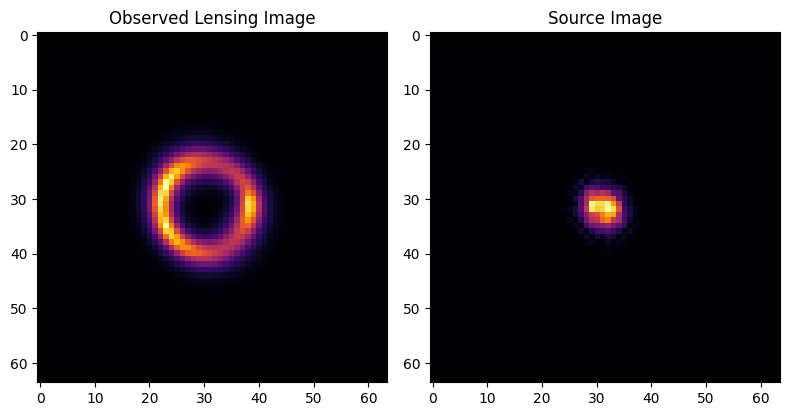

In [10]:
image = np.load("/kaggle/input/train-deeplense1-2/Model_II-001/Model_II/axion/axion_sim_100000344109220308579478752698140600138.npy", allow_pickle=True)[0]
phy = Physics()
source = phy.image_to_source(image, E_r=1)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].imshow(image, cmap="inferno")
axs[0].set_title("Observed Lensing Image")
axs[1].imshow(source, cmap="inferno")
axs[1].set_title("Source Image")
plt.tight_layout()
plt.show()


## Encoder block

In [11]:
class PhysicsInformedEncoder(nn.Module):
    def __init__(self, image_size, patch_size, embedding_dim, num_patches, num_heads,
                 hidden_dim, transformer_block_activation_function, num_transformer_block,
                 device: torch.device, k_max, k_min, num_hidden_layer=1, dropout=0.1, pixel_scale=0.101,
                 min_angle=-3.323, max_angle=3.232, mag=1):
        super().__init__()

        self.image_size = image_size
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.num_patches = num_patches
        self.num_heads = num_heads
        self.hidden_dim = hidden_dim
        self.k_max = k_max
        self.k_min = k_min
        self.transformer_block_activation_function = transformer_block_activation_function
        self.num_transformer_block = num_transformer_block
        self.device = device
        self.dropout = dropout
        self.pixel_scale = pixel_scale
        self.min_angle = min_angle
        self.max_angle = max_angle
        self.source_mag = mag

        self.transformer = nn.ModuleList()

        for _ in range(self.num_transformer_block):
            self.transformer.append(
                TransformerLSABlock(embedding_dim=self.embedding_dim,
                                    num_head=self.num_heads,
                                    num_patches=self.num_patches,
                                    num_hidden_neurons=self.hidden_dim,
                                    num_hidden_layers=num_hidden_layer,
                                    activation_function=self.transformer_block_activation_function,
                                    device=self.device,
                                    dropout=dropout)
            )

        # Adding a compressor to give us the deflection angle for each pixel
        self.transformer.append(nn.Flatten())
        self.total_features = (self.num_patches + 1) * self.embedding_dim
        self.transformer.append(nn.Linear(self.total_features, self.image_size*self.image_size))
        self.physics = Physics(mag=1)
        self.imones = torch.ones((self.image_size,self.image_size)).to(self.device)
        self.imones_1d = torch.ones((self.image_size*self.image_size)).to(self.device)
        # Create a grid for image coordinates
        self.profile_size = self.image_size
        self.half_profile_size = self.profile_size // 2

    def image_to_source(self, image, centre=None, E_r=None, deflection=None, gradient=None):
        length, width = image.shape
        pixel_width = (self.max_angle - self.min_angle) / length
        if centre is None:
            centre = (length // 2, width // 2)
        centre_x, centre_y = centre
        if False:
            centre_x = centre_x.item()
            centre_y = centre_y.item()
        
        range_indices_x = torch.arange(-(centre_x - 1), length - (centre_x - 1), device=self.device)
        range_indices_y = torch.arange(-(centre_y - 1), width - (centre_y - 1), device=self.device)

        x, y = torch.meshgrid(range_indices_x, range_indices_y, indexing='ij')
        x, y = x * pixel_width, y * pixel_width

        r = torch.sqrt(x**2 + y**2)
        mask = (r == 0)
        r[mask] = 1

        if deflection is not None:
            if deflection.shape != (length, width):
                raise ValueError(f"The deflection should be of shape (2, {length}, {width}) but got {deflection.shape}")
            xdef = (deflection * x) / r
            ydef = (deflection * y) / r
        elif gradient is not None:
            if gradient.shape != image.shape:
                raise ValueError("The gradient and image should be of the same shape")
            xdef = np.gradient(gradient, axis=0)
            ydef = np.gradient(gradient, axis=1)
        elif E_r is not None:
            k = torch.ones((length, width), device=self.device) * E_r
            xdef = (k * x) / r
            ydef = (k * y) / r
        else:
            raise ValueError("Both deflection and gradient cannot be None")

        bx = x - xdef
        by = y - ydef

        bx, by = bx / pixel_width, by / pixel_width

        bx = torch.clamp(bx + centre_x * self.source_mag, 0, length * self.source_mag - 1).long()
        by = torch.clamp(by + centre_y * self.source_mag, 0, width * self.source_mag - 1).long()

        # Initialize the output image tensor
        sourceimage = torch.zeros((length * self.source_mag, width * self.source_mag), dtype=torch.float, device=self.device)
        
        # Flatten the image and coordinates
        flat_image = image.view(-1)
        flat_bx = bx.view(-1)
        flat_by = by.view(-1)

        # Calculate 1D indices
        one_d_indices = flat_bx * (width * self.source_mag) + flat_by

        # Scatter add the values to sourceimage
        sourceimage_flat = sourceimage.view(-1)
        count  = torch.zeros_like(sourceimage_flat)
        sourceimage_flat = sourceimage_flat.scatter_add(0, one_d_indices, flat_image)
        count = count.scatter_add(0, one_d_indices, self.imones_1d)
        mask = count!=0
        sourceimage_flat[mask]/=count[mask]
        sourceimage = sourceimage_flat.view(sourceimage.shape)

        return sourceimage


    def forward(self, input_images, patches,distortion):
        # Move tensors to the appropriate device
        input_images = input_images.to(self.device)
        distortion = distortion.to(self.device)
        patches = patches.to(self.device)

        batch_size = input_images.shape[0]

        # Process patches through transformer layers
        k_sigmoid = patches
        for layer in self.transformer:
            k_sigmoid = layer(k_sigmoid)

        # Extract output components from k_sigmoid
        k_sigmoid = k_sigmoid.view(batch_size,64,64)
        distortion = distortion.view(batch_size,64,64)
        einstein_angle = k_sigmoid*distortion

        # Reshape input images
        input_images = input_images.view(batch_size, self.image_size, self.image_size)

        # Initialize source_image tensor
        source_image = torch.zeros_like(input_images)

        # Transform each image in the batch
        for i in range(batch_size):
            source_image_np = self.image_to_source(image=input_images[i], E_r=einstein_angle[i])
            source_image[i] = source_image_np

        return k_sigmoid,source_image


In [12]:
phy = PhysicsInformedEncoder(image_size=64, 
                             patch_size=32, 
                             embedding_dim = 384, 
                             num_patches = 4, 
                             num_heads=8,
                             hidden_dim=64, 
                             transformer_block_activation_function=nn.ReLU, 
                             num_transformer_block = 2,
                             device = "cuda", 
                             k_max = 1.2, 
                             k_min = 0.8).to("cuda")

In [13]:
tokenizer = ShiftPatchTokenizer(image_size=64, embedding_size=384, patch_size=32, num_channels=1, translation_mode="rectangular", device="cpu")
input_tensor = torch.randn(64, 1, 64, 64)  
output = tokenizer(input_tensor)
print(output.shape)  


torch.Size([64, 5, 384])


In [14]:
start = time.time()
source = phy(input_tensor,output,input_tensor)
end = time.time()
print(end-start)

0.49215006828308105


In [15]:
class Flatten(nn.Module):
    """
    This module flattens the input tensor into a 2D tensor with a fixed
    number of neurons (elements) in the second dimension.

    Args:
        num_neurons_flatten (int): Number of neurons to flatten the input tensor to.

    Attributes:
        num_neurons_flatten (int): Number of neurons to flatten the input tensor to.

    Returns:
        Flattened tensor with shape `[batch_size, num_neurons_flatten]`.
    """

    def __init__(self, num_neurons_flatten: int):
        # Initialize the superclass
        super(Flatten, self).__init__()
        self.num_neurons_flatten = num_neurons_flatten

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Flatten the tensor to the specified number of neurons
        return x.contiguous().view(-1, self.num_neurons_flatten)


In [16]:
import timm

In [17]:
class SiameseNet(nn.Module):
    def __init__(self, model_name, n_class, num_hidden_neurons, num_hidden_layers, feedforward_activation, dropout_rate, mode="concatenate",upsample = False):
        super(SiameseNet, self).__init__()
        self.model_name = model_name
        self.model = timm.create_model(self.model_name, pretrained=True)
        self.mode = mode
        self.upsample = upsample
        if upsample:
            self.resize = nn.ModuleList([
                nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(1, 1)),
                nn.Conv2d(in_channels=2, out_channels=3, kernel_size=(1, 1)),
                nn.Upsample(size=(224, 224), mode='bilinear', align_corners=False)
            ])
            
        else:
            self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            self.fc = nn.Linear(512,3)
        

        if self.mode == "concatenate":
            num_feats = 2000
        elif self.mode == "difference":
            num_feats = 1000
        else:
            raise ValueError("Mode must be 'concatenate' or 'difference'")
        
        self.feedforward_layer = FeedForwardBlock(
                in_dim=num_feats,
                out_dim=n_class,
                hidden_dim=num_hidden_neurons,
                num_hidden_layers=num_hidden_layers,
                activation_function=feedforward_activation,
                task_type='multiclass',
                dropout=dropout_rate
            )
        
        
    def forward(self, source, images):
        if self.upsample:
            for layer in self.resize:
                source = layer(source)
                images = layer(images)
        
        source_feats = self.model(source)
        images_feats = self.model(images)
        
        if self.mode == "concatenate":
            final_feats = torch.cat((source_feats, images_feats), dim=1)
        elif self.mode == "difference":
            final_feats = source_feats - images_feats
        
        predictions = self.feedforward_layer(final_feats)
        return predictions


In [18]:
class Lensiformer(nn.Module):
    def __init__(self,
                 image_size: int,
                 patch_size: int,
                 embed_dim: int,
                 in_channels: int,
                 num_classes: int,
                 num_heads: int,
                 num_hidden_neurons: int,
                 num_hidden_layers: int,
                 transformer_activation: nn.Module,
                 feedforward_activation: nn.Module,
                 num_transformer_blocks: int,
                 device: torch.device,
                 dropout_rate: float = 0.1):
        """
        Initializes Lensiformer, a Relativistic Physics-Informed Vision Transformer (PIViT) Architecture for Dark Matter Morphology.

        Args:
            image_size (int): Size of the input image (assumed square).
            patch_size (int): Size of each image patch (assumed square).
            embed_dim (int): Dimension of the embedding space.
            in_channels (int): Number of input channels.
            num_classes (int): Number of target classes.
            num_heads (int): Number of attention heads.
            num_hidden_neurons (int): Number of neurons in hidden layers.
            num_hidden_layers (int): Number of hidden layers.
            transformer_activation (nn.Module): Activation function for transformer blocks.
            feedforward_activation (nn.Module): Activation function for feedforward layers.
            num_transformer_blocks (int): Number of transformer blocks.
            device (torch.device): Computational device (CPU/GPU).
            dropout_rate (float, optional): Dropout rate. Defaults to 0.1.
        """
        super(Lensiformer, self).__init__()

        # Initialize parameters
        self.image_size = image_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.num_heads = num_heads
        self.num_hidden_neurons = num_hidden_neurons
        self.num_hidden_layers = num_hidden_layers
        self.transformer_activation = transformer_activation
        self.feedforward_activation = feedforward_activation
        self.num_transformer_blocks = num_transformer_blocks
        self.device = device
        self.dropout_rate = dropout_rate

        # Initialize modules
        self.initial_tokenizer = ShiftPatchTokenizer(image_size=image_size, embedding_size=embed_dim, patch_size=patch_size, num_channels=in_channels, translation_mode="diagonal", device=device)
        self.secondary_tokenizer = ShiftPatchTokenizer(image_size=image_size, embedding_size=embed_dim, patch_size=patch_size, num_channels=in_channels, translation_mode="diagonal", device=device)
        self.tertiary_tokenizer = ShiftPatchTokenizer(image_size=image_size, embedding_size=embed_dim, patch_size=patch_size, num_channels=in_channels, translation_mode="diagonal", device=device)
        self.encoder = PhysicsInformedEncoder(image_size=image_size, 
                                              patch_size=patch_size, 
                                              embedding_dim = embed_dim, 
                                              num_patches = self.initial_tokenizer.get_num_patches(), 
                                              num_heads=num_heads,
                                              hidden_dim=num_hidden_neurons, 
                                              transformer_block_activation_function=feedforward_activation, 
                                              num_transformer_block = num_transformer_blocks,
                                              device = device, 
                                              k_max = 1.2, 
                                              k_min = 0.8)

        # Transformer blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerLSABlock(embedding_dim = embed_dim,
                                num_head = num_heads,
                                num_patches = self.initial_tokenizer.get_num_patches(),
                                num_hidden_neurons=num_hidden_neurons,
                                num_hidden_layers=1,
                                activation_function=transformer_activation,
                                device=device)
            for _ in range(num_transformer_blocks)
        ])

        # Flatten and FeedForward layers
        self.flatten_layer = Flatten((self.initial_tokenizer.get_num_patches() + 1) * embed_dim)
        self.feedforward_layer = FeedForwardBlock(in_dim = self.flatten_layer.num_neurons_flatten,
                                                  out_dim = num_classes,
                                                  hidden_dim = num_hidden_neurons,
                                                  num_hidden_layers = num_hidden_layers,
                                                  activation_function = feedforward_activation,
                                                  task_type = 'multiclass',
                                                  dropout=dropout_rate)
        """self.siam = SiameseNet("resnet18",
                               num_classes,
                               num_hidden_neurons,
                               num_hidden_layers,
                               feedforward_activation,
                               dropout_rate,
                               mode = "difference"
                              )"""
        #base_network = BaseNetwork()
        #self.siam = SiameseNetwork(base_network, 2)
        
    def invert_lens(self, images: torch.Tensor) -> torch.Tensor:
        batch_size = images.size(0)
        images_T = images.reshape(batch_size, 1, self.image_size, self.image_size)
        # Tokenize input images into patches
        initial_patches = self.initial_tokenizer(images_T)

        # Encode images and patches
        lens_corrected_images = self.encoder(images, initial_patches)

        return lens_corrected_images

    def forward(self, images: torch.Tensor,distortions) -> torch.Tensor:
        """
        Forward pass through the Physics-Informed Vision Transformer.

        Args:
            images (Tensor): Input images with shape (batch_size, channels, height, width).

        Returns:
            Tensor: Model predictions with shape (batch_size, num_classes).
        """
        images = images.to(self.device)
        distortions = distortions.to(self.device)
        batch_size = images.size(0)

        # Tokenize input images into patches
        dis_patches = self.tertiary_tokenizer(distortions.reshape(batch_size,1,self.image_size,self.image_size))
        initial_patches = self.initial_tokenizer(images.reshape(batch_size, 1, self.image_size, self.image_size))
        #print(initial_patches.shape)
        # Encode images and patches
        #print("images",images.shape)
        
        info,lens_corrected_images = self.encoder(images, initial_patches,distortions)
        source = lens_corrected_images.view(batch_size,1,64,64)
        source = source.to(self.device)
        
        source_patches = self.secondary_tokenizer(source)
        concatenated = torch.concat((dis_patches,source_patches-initial_patches),dim=2)
        # Pass through transformer blocks
        verbose = 2
        if verbose ==0:
            print("source_shape = ",source_patches.shape)
            print("observed_shape = ",initial_patches.shape)
            print("distortion_shape = ",dis_patches.shape)
            print("concat feats",concatenated.shape)

        for block in self.transformer_blocks:
            concatenated = block(key = dis_patches,value = initial_patches,query = source_patches)
        # Flatten the patches
        flattened_patches = self.flatten_layer(concatenated)
        # Generate final predictions
        final_predictions = self.feedforward_layer(flattened_patches)
        return info,source,final_predictions


# Lensiformer(Previous Year works)

In [19]:
lens  = Lensiformer(image_size=64,
                    patch_size=32,
                    embed_dim=384,
                    in_channels=1,
                    num_classes=3,
                    num_heads=16,
                    num_hidden_neurons=64,
                    num_hidden_layers=1,
                    transformer_activation=nn.ELU,
                    feedforward_activation=nn.ELU,
                    num_transformer_blocks = 1,
                    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
                    ).to("cuda")

In [20]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    

In [21]:
imagess = torch.randn(64,1,64,64)
dis = torch.randn(64,1,64,64)

In [22]:
import time

In [23]:
start = time.time()
info,source,final_predictions = lens(imagess,dis)
end = time.time()
print(end-start)

0.45856642723083496


In [24]:
count_parameters(lens)

+------------------------------------------------------+------------+
|                       Modules                        | Parameters |
+------------------------------------------------------+------------+
|          initial_tokenizer.class_embedding           |    384     |
|             initial_tokenizer.positional             |    1920    |
|          initial_tokenizer.tokenizer.weight          |  1966080   |
|           initial_tokenizer.tokenizer.bias           |    384     |
|         secondary_tokenizer.class_embedding          |    384     |
|            secondary_tokenizer.positional            |    1920    |
|         secondary_tokenizer.tokenizer.weight         |  1966080   |
|          secondary_tokenizer.tokenizer.bias          |    384     |
|          tertiary_tokenizer.class_embedding          |    384     |
|            tertiary_tokenizer.positional             |    1920    |
|         tertiary_tokenizer.tokenizer.weight          |  1966080   |
|          tertiary_

15786693

## the number of parameters for the lensiformer is around 15 millions 

## LOADING THE DATA 

In [25]:
from tqdm import tqdm

if CONFIG.dont_waste_runtime:
    train_data = np.load("/kaggle/input/model2data/model2_train_data.npy")
    train_label = np.load("/kaggle/input/model2data/model2_train_label.npy")
else:
    train_dir = "/kaggle/input/train-deeplense1-2/Model_II-001/Model_II"
    classes = os.listdir(train_dir)
    class_dict = {"axion": 0, "cdm": 1, "no_sub": 2}
    train_data = []
    train_label = []

    for i in range(len(classes)):
        dirr = os.path.join(train_dir, classes[i])
        print(f"Processing class: {classes[i]}")
        for names in tqdm(os.listdir(dirr)):
            filedir = os.path.join(dirr, names)
            nparray = np.load(filedir, allow_pickle=True)
            if nparray.shape[0] != 64:
                train_data.append(nparray[0])
            else:
                train_data.append(nparray)
            train_label.append(class_dict[classes[i]])

    # Convert lists to numpy arrays for further processing
    train_data = np.array(train_data)
    train_label = np.array(train_label)

print(f"Data shape: {train_data.shape}")
print(f"Labels shape: {train_label.shape}")


Data shape: (89104, 64, 64)
Labels shape: (89104,)


In [26]:
np.save("model2_train_data.npy",train_data)
np.save("model2_train_label.npy",train_label)

In [27]:
split = True

In [28]:
if not split:
    test_dir = "/kaggle/input/train-deeplense1-2/Model_III-002/Model_III"
    classes = os.listdir(test_dir)
    class_dict = {"axion": 0, "cdm": 1, "no_sub": 2}
    test_data = []
    test_label = []

    for i in range(len(classes)):
        dirr = os.path.join(test_dir, classes[i])
        count = 0
        for names in tqdm(os.listdir(dirr)):
            filedir = os.path.join(dirr, names)
            nparray = np.load(filedir, allow_pickle=True)
            if nparray.shape[0] != 64:
                test_data.append(nparray[0])
            else:
                test_data.append(nparray)
            test_label.append(class_dict[classes[i]])
            count += 1

    # Convert lists to numpy arrays for further processing
    test_data = np.array(test_data)
    test_label = np.array(test_label)

    print(f"Data shape: {test_data.shape}")
    print(f"Labels shape: {test_label.shape}")

if split:
    from sklearn.model_selection import train_test_split
    train_data,test_data,train_label,test_label = train_test_split(train_data,train_label,test_size = 0.2)

# Physics-Informed Preprocessing

Due to the influence of the lensing galaxy, spacetime bends, causing light to bend and altering its normal path. This leads to significant changes in image intensity distribution. 

**Concept:**
- The gravitational lensing effect causes intensity variations in the observed image, especially in regions with dark matter.

**Approach:**
- Calculate the gradient/differential of the image intensity distribution.
- Intensity changes drastically in areas where dark matter is present, allowing for better detection and analysis of these regions.


In [29]:
def preprocess(image):
    imax = np.max(image)
    log = np.square(np.log(imax/image))
    gradient = np.gradient(np.gradient(log,axis =0),axis=1)
    tan = np.tanh(gradient)
    absolute = np.abs(tan)
    return absolute 

## the transformation can be represented as follows 

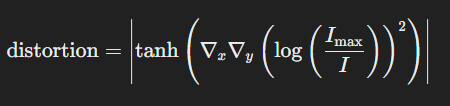

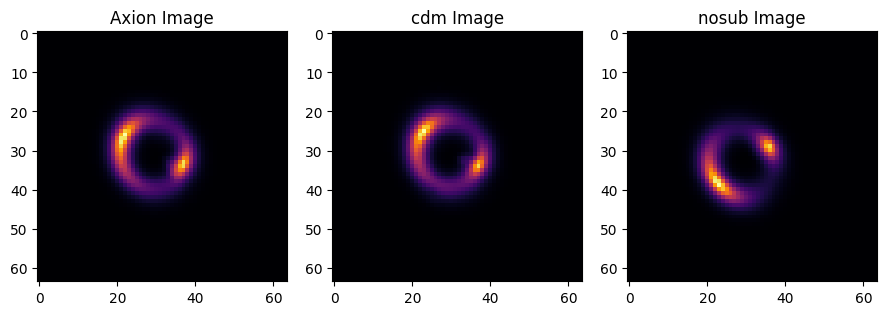

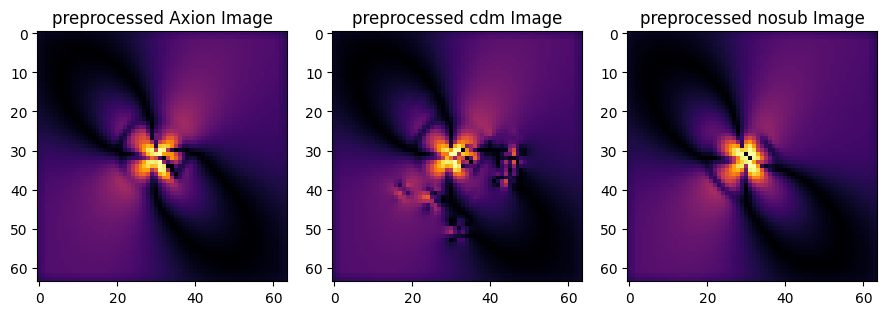

In [30]:
axion = np.load("/kaggle/input/train-deeplense1-2/Model_II-001/Model_II/axion/axion_sim_100084953578079617776821445184190256764.npy",allow_pickle = True)[0]
cdm = np.load("/kaggle/input/train-deeplense1-2/Model_II-001/Model_II/cdm/cdm_sim_100139434468354273490164714731456867252.npy",allow_pickle = True)
nosub = np.load("/kaggle/input/train-deeplense1-2/Model_II-001/Model_II/no_sub/no_sub_sim_100043654144385630537921390101531439263.npy",allow_pickle = True)
fig, axs = plt.subplots(1, 3, figsize=(9, 3))

axs[0].imshow(axion, cmap="inferno")
axs[0].set_title("Axion Image")
axs[1].imshow(cdm, cmap="inferno")
axs[1].set_title("cdm Image")
axs[2].imshow(nosub, cmap="inferno")
axs[2].set_title("nosub Image")
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(9, 3))

axs[0].imshow(preprocess(axion), cmap="inferno")
axs[0].set_title("preprocessed Axion Image")
axs[1].imshow(preprocess(cdm), cmap="inferno")
axs[1].set_title("preprocessed cdm Image")
axs[2].imshow(preprocess(nosub), cmap="inferno")
axs[2].set_title("preprocessed nosub Image")
plt.tight_layout()
plt.show()

### Clearly, lensing images that seem very similar to each other can have very different differentials. The points where there are sudden changes in intensity may indicate the presence of dark matter.

In [31]:
model2 = True
if not model2:
    train_data = np.load("/kaggle/input/real-galaxy-tiny-dataset/data_train.npy")
    test_data = np.load("/kaggle/input/real-galaxy-tiny-dataset/data_test.npy")
    train_target = np.load("/kaggle/input/real-galaxy-tiny-dataset/labels_train.npy")
    test_target = np.load("/kaggle/input/real-galaxy-tiny-dataset/labels_test.npy")
    
    test_label = np.argmax(test_target,axis=1)
    train_label = np.argmax(train_target,axis=1)

In [32]:
class Dataset:
    def __init__(self, data, target):
        self.data = data
        self.target = target

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        #image/=np.max(image)
        tar = self.target[idx]
        pre = preprocess(image)
        return torch.tensor(image, dtype=torch.float),torch.tensor(pre, dtype=torch.float), torch.tensor(tar, dtype=torch.long)



In [33]:
train_dataset = Dataset(train_data,train_label)
test_dataset = Dataset(test_data,test_label)


In [34]:
train_dataset[0]

(tensor([[8.4260e-10, 1.2258e-09, 1.8854e-09,  ..., 2.9156e-12, 1.6667e-12,
          1.0230e-12],
         [1.1937e-09, 1.7500e-09, 2.7149e-09,  ..., 4.4709e-12, 2.5420e-12,
          1.5527e-12],
         [1.7878e-09, 2.6440e-09, 4.1422e-09,  ..., 7.3302e-12, 4.1426e-12,
          2.5165e-12],
         ...,
         [2.2762e-10, 3.8152e-10, 6.8833e-10,  ..., 8.3106e-09, 4.8351e-09,
          3.0127e-09],
         [1.4334e-10, 2.3878e-10, 4.2789e-10,  ..., 5.9907e-09, 3.5184e-09,
          2.2109e-09],
         [9.6104e-11, 1.5921e-10, 2.8359e-10,  ..., 4.5173e-09, 2.6750e-09,
          1.6934e-09]]),
 tensor([[0.0686, 0.0627, 0.0556,  ..., 0.1755, 0.1529, 0.1317],
         [0.0635, 0.0562, 0.0475,  ..., 0.1998, 0.1752, 0.1519],
         [0.0574, 0.0485, 0.0378,  ..., 0.2245, 0.1978, 0.1725],
         ...,
         [0.1872, 0.2131, 0.2407,  ..., 0.0335, 0.0465, 0.0569],
         [0.1656, 0.1895, 0.2149,  ..., 0.0401, 0.0511, 0.0601],
         [0.1447, 0.1665, 0.1898,  ..., 0.0458, 0.0

In [35]:
from torch.utils.data import DataLoader
train_looader = DataLoader(train_dataset,batch_size = 64)
test_looader = DataLoader(test_dataset,batch_size = 64)

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [37]:
from sklearn.metrics import f1_score
def plot_model_metrics(mean_loss_train,mean_f1_train,model_name,mode):
    """
    Plots the training loss and ROC-AUC over epochs.

    Args:
        mean_loss_train (list): List of mean training loss over epochs.
        mean_auc_train (list): List of mean training ROC-AUC over epochs.

    Returns:
        None
    """
    # Plot training and testing loss over epochs
    plt.figure()
    plt.plot(mean_loss_train, label=mode)
    plt.title(model_name+' Loss - Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.plot(mean_f1_train, label=mode)
    plt.title(model_name+' F1 - Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('F1')
    plt.legend()
    plt.show()

    print('\n\n')


def train_final_model(model,total_training_loader,total_test_loader,n_epochs,optimizer,criterion,device,model_name):

    """

    Trains a PyTorch model.

    Args:

    - model (nn.Module): the PyTorch model to be trained
    - train_loader (DataLoader): DataLoader containing the training set
    - n_epochs (int): number of training epochs
    - optimizer (optim.Optimizer): the optimizer to use for training
    - criterion (nn.Module): the loss function to use for training
    - device (str): device to run the model on (e.g. 'cpu' or 'cuda')

    Returns:

    - mean_loss_train (list): mean loss per epoch for the training set
    - mean_auc_train (list): mean ROC-AUC per epoch for the test set


    """

    # initialize lists to keep track of metrics
    mean_loss_train = []
    mean_f1_train = []
    mean_loss_test = []
    mean_f1_test = []
    best_f1 = -2

    # loop over epochs
    for it in range(n_epochs):

        # initialize list to keep track of train loss for this epoch
        train_loss = []
        train_f1 = []
        y_true = []
        y_pred = []

        # set model to train mode
        model.train()

        # loop over training data
        for images,dis, targets in tqdm(total_training_loader):

            # move data to device
            images,dis, targets = images.to(device),dis.to(device), targets.to(device)
            batch = images.shape[0]
            images = images.view(batch,1,64,64)
            # zero the gradients
            optimizer.zero_grad()
            # forward pass
            if model_name == "resnet":
                outputs = model(images)
            else:
                info,source,outputs = model(images,dis)
            # compute loss
            loss = criterion(outputs, targets)

            # backward pass and optimization step
            loss.backward()
            optimizer.step()
            #print("epochloss = ",loss)
            # append loss to train_loss list
            train_loss.append(loss.item())

            # ROC Score
            preds = outputs.detach().cpu().numpy()
            labels = targets.detach().cpu().numpy()

            preds = [np.argmax(pred) for pred in preds]
            y_true.append(labels)
            y_pred.append(preds)
            train_f1.append(f1_score(labels,preds,average='micro'))
            #print(train_f1)
        y_true = np.hstack(y_true).reshape(-1)
        y_pred = np.hstack(y_pred).reshape(-1)
        mat = confusion_matrix(y_true,y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=mat)
        disp.plot()
        plt.show()

        # initialize list to keep track of train loss for this epoch
        test_loss = []
        test_f1 = []

        # set model to train mode
        model.eval()
        y_true = []
        y_pred = []

        # turn off gradients for evaluation
        with torch.no_grad():

          # loop over training data
            for images,dis, targets in tqdm(total_test_loader):
                # move data to device
                images,dis, targets = images.to(device),dis.to(device), targets.to(device)
                batch = images.shape[0]
                images = images.view(batch,1,64,64)
                # forward pass
                if model_name == "resnet":
                    outputs = model(images)
                else:
                    info,source,outputs = model(images,dis)

                # compute loss
                loss = criterion(outputs, targets)

                # append loss to train_loss list
                test_loss.append(loss.item())

                # ROC Score
                preds = outputs.detach().cpu().numpy()
                labels = targets.detach().cpu().numpy()


                preds = [np.argmax(pred) for pred in preds]
                y_true.append(labels)
                y_pred.append(preds)
                #print(labels)
                #print(preds)
                test_f1.append(f1_score(labels,preds,average='micro'))

            y_true = np.hstack(y_true).reshape(-1)
            y_pred = np.hstack(y_pred).reshape(-1)
            mat = confusion_matrix(y_true,y_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=mat)
            disp.plot()
            plt.show()


        # append the mean train loss for this epoch to the list of train losses
        mean_loss_train.append(np.mean(train_loss))
        mean_f1_train.append(np.mean(train_f1))
        mean_loss_test.append(np.mean(test_loss))
        mean_f1_test.append(np.mean(test_f1))

        if mean_f1_test[-1] > best_f1:
            best_f1 = mean_f1_test[-1]
            torch.save(model.state_dict(), "/kaggle/working/"+str(model_name)+"_best.pth")
            torch.save(model,"/kaggle/working/"+str(model_name)+"_complete.pth")


        # print epoch metrics
        print(f'Epoch {it}/{n_epochs}, Train Loss: {mean_loss_train[-1]:.4f}, Train F1: {mean_f1_train[-1]:.4f},Test Loss: {mean_loss_test[-1]:.4f}, Test F1: {mean_f1_test[-1]:.4f}, ')


    # return lists of mean train
    return mean_loss_train,mean_f1_train,mean_loss_test,mean_f1_test


In [38]:
lens  = Lensiformer(image_size=64,
                    patch_size=32,
                    embed_dim=384,
                    in_channels=1,
                    num_classes=3,
                    num_heads=16,
                    num_hidden_neurons=64,
                    num_hidden_layers=3,
                    transformer_activation=nn.ELU,
                    feedforward_activation=nn.ELU,
                    num_transformer_blocks = 1,
                    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
                    ).to("cuda")

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(lens.parameters(),lr=1e-4)


In [40]:
import warnings
warnings.filterwarnings("ignore")

100%|██████████| 1114/1114 [01:44<00:00, 10.70it/s]


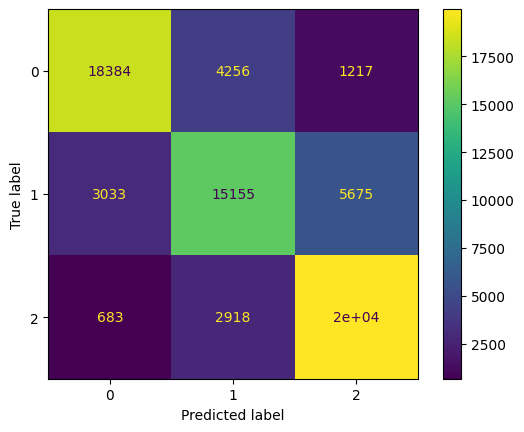

100%|██████████| 279/279 [00:22<00:00, 12.54it/s]


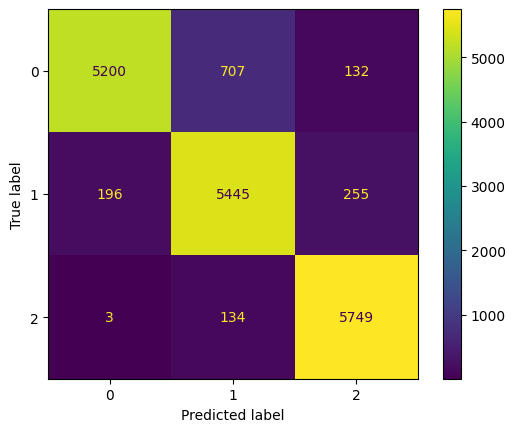

Epoch 0/20, Train Loss: 0.7919, Train F1: 0.7506,Test Loss: 0.6292, Test F1: 0.9199, 


100%|██████████| 1114/1114 [01:40<00:00, 11.08it/s]


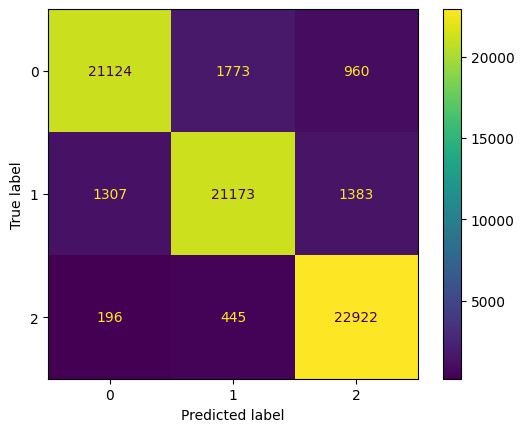

100%|██████████| 279/279 [00:22<00:00, 12.42it/s]


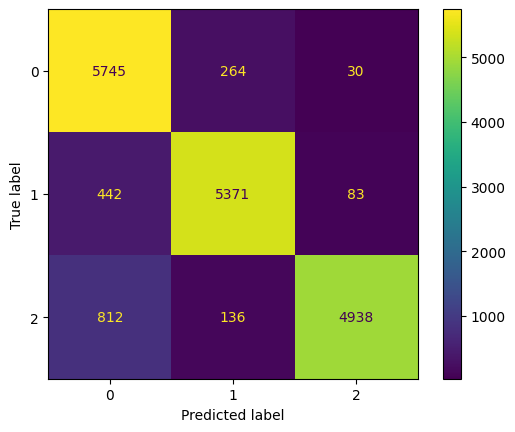

Epoch 1/20, Train Loss: 0.6351, Train F1: 0.9149,Test Loss: 0.6452, Test F1: 0.9009, 


100%|██████████| 1114/1114 [01:41<00:00, 11.02it/s]


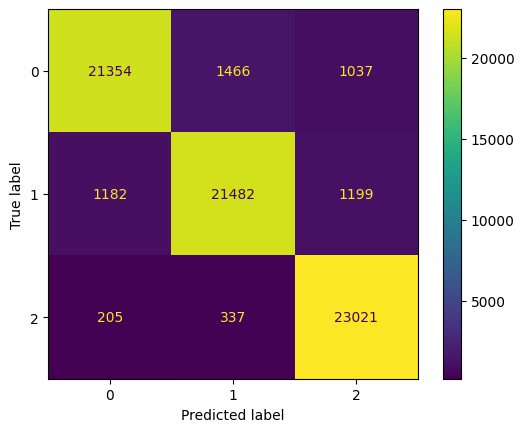

100%|██████████| 279/279 [00:23<00:00, 12.06it/s]


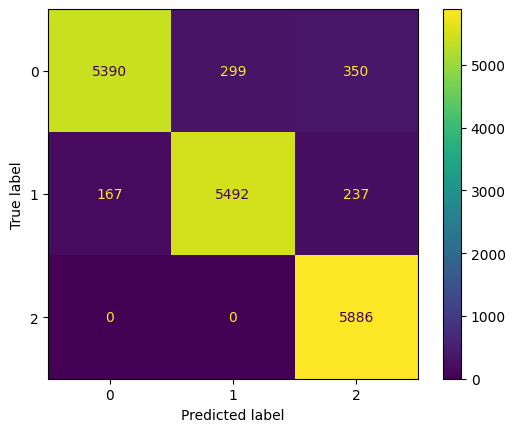

Epoch 2/20, Train Loss: 0.6262, Train F1: 0.9239,Test Loss: 0.6103, Test F1: 0.9408, 


100%|██████████| 1114/1114 [01:39<00:00, 11.17it/s]


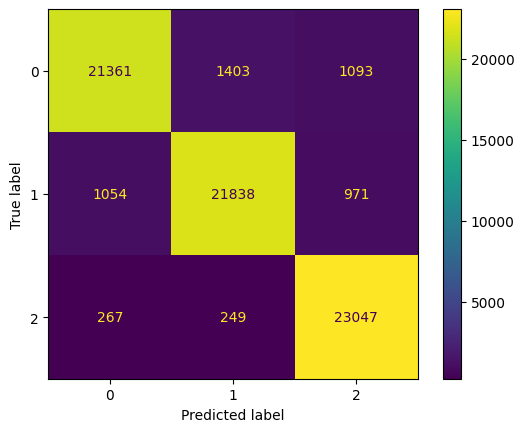

100%|██████████| 279/279 [00:22<00:00, 12.61it/s]


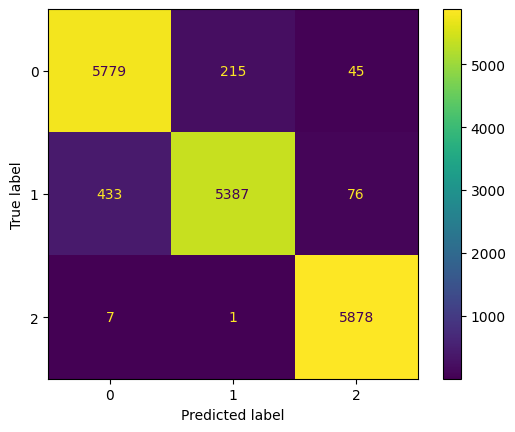

Epoch 3/20, Train Loss: 0.6211, Train F1: 0.9293,Test Loss: 0.5949, Test F1: 0.9564, 


100%|██████████| 1114/1114 [01:41<00:00, 10.93it/s]


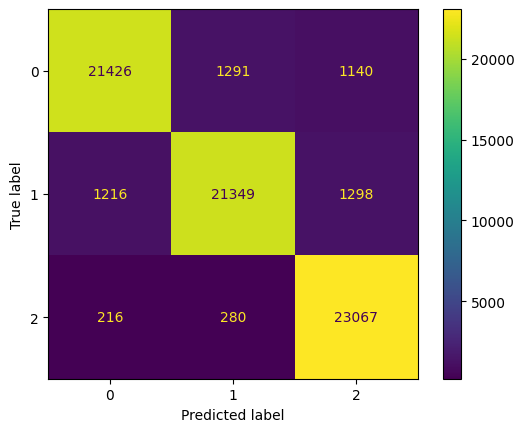

100%|██████████| 279/279 [00:22<00:00, 12.57it/s]


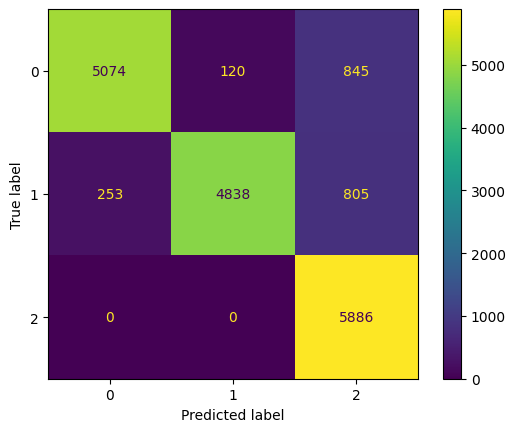

Epoch 4/20, Train Loss: 0.6269, Train F1: 0.9237,Test Loss: 0.6642, Test F1: 0.8865, 


100%|██████████| 1114/1114 [01:41<00:00, 10.96it/s]


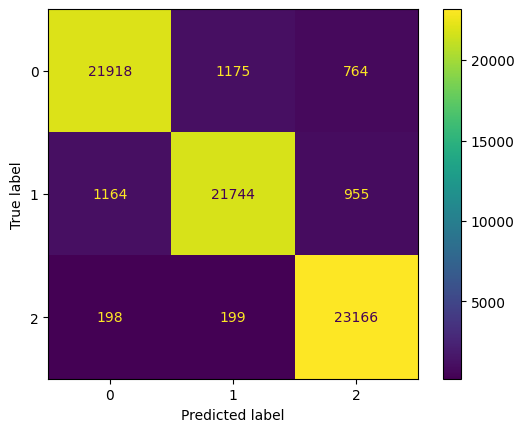

100%|██████████| 279/279 [00:21<00:00, 12.69it/s]


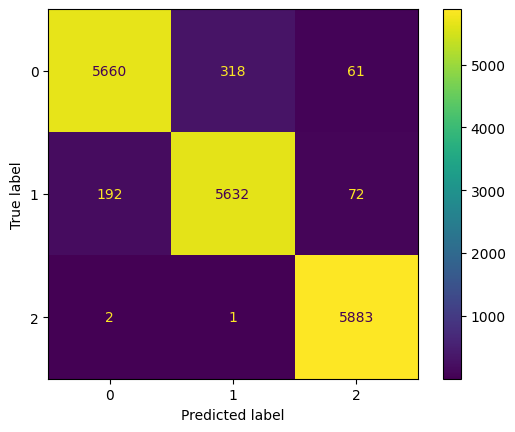

Epoch 5/20, Train Loss: 0.6129, Train F1: 0.9375,Test Loss: 0.5870, Test F1: 0.9638, 


100%|██████████| 1114/1114 [01:41<00:00, 11.02it/s]


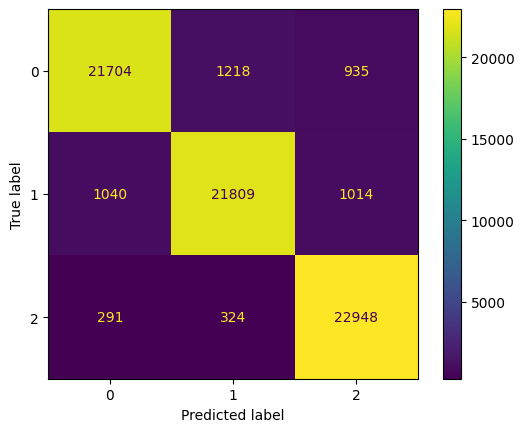

100%|██████████| 279/279 [00:22<00:00, 12.13it/s]


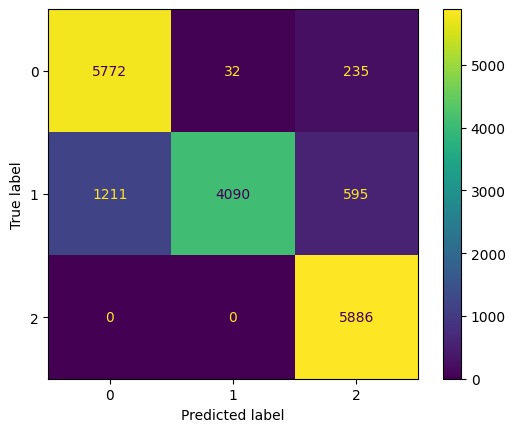

Epoch 6/20, Train Loss: 0.6181, Train F1: 0.9324,Test Loss: 0.6658, Test F1: 0.8838, 


100%|██████████| 1114/1114 [01:42<00:00, 10.83it/s]


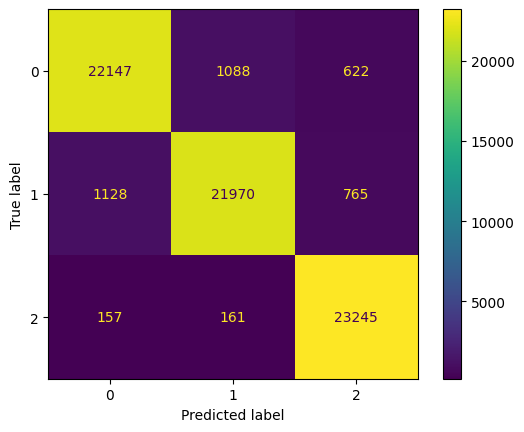

100%|██████████| 279/279 [00:22<00:00, 12.20it/s]


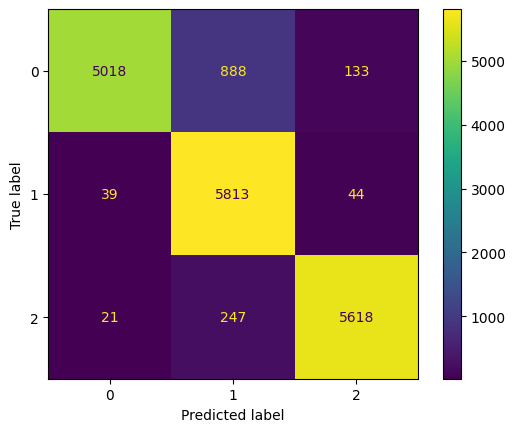

Epoch 7/20, Train Loss: 0.6055, Train F1: 0.9450,Test Loss: 0.6274, Test F1: 0.9230, 


100%|██████████| 1114/1114 [01:40<00:00, 11.10it/s]


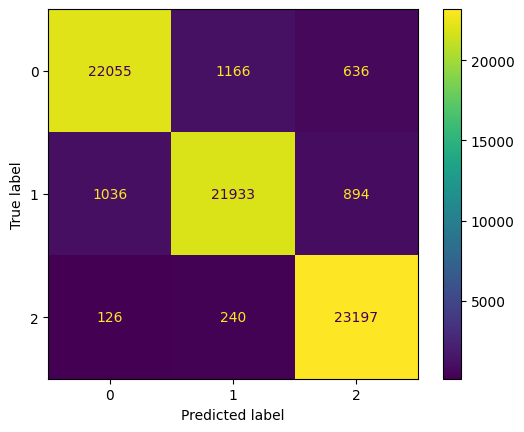

100%|██████████| 279/279 [00:22<00:00, 12.16it/s]


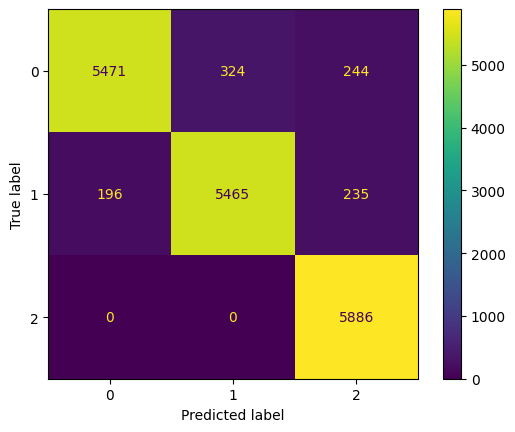

Epoch 8/20, Train Loss: 0.6082, Train F1: 0.9425,Test Loss: 0.6064, Test F1: 0.9439, 


100%|██████████| 1114/1114 [01:45<00:00, 10.53it/s]


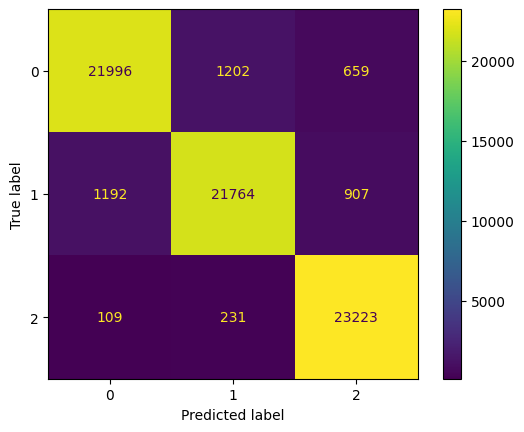

100%|██████████| 279/279 [00:22<00:00, 12.21it/s]


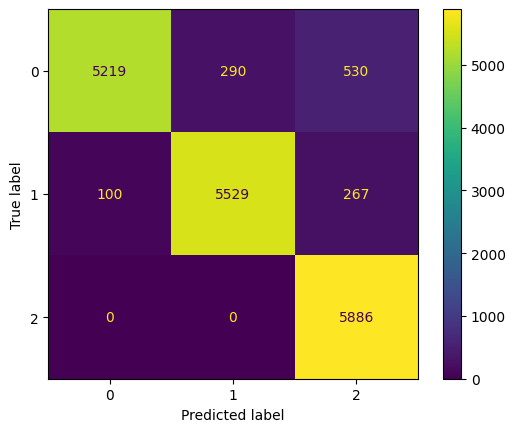

Epoch 9/20, Train Loss: 0.6110, Train F1: 0.9397,Test Loss: 0.6174, Test F1: 0.9333, 


100%|██████████| 1114/1114 [01:45<00:00, 10.56it/s]


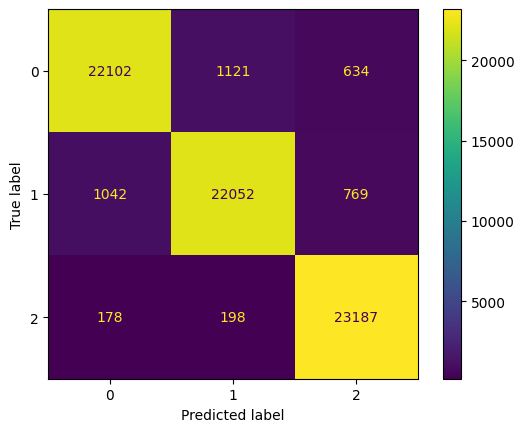

100%|██████████| 279/279 [00:22<00:00, 12.14it/s]


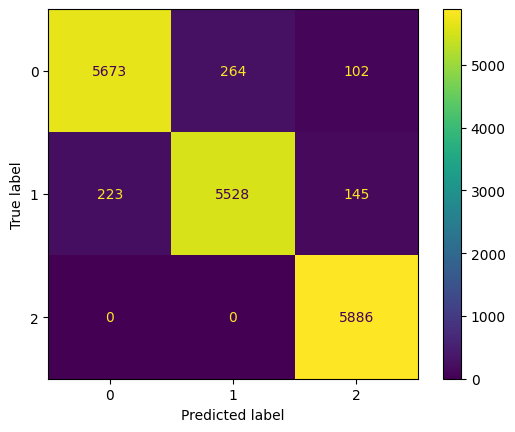

Epoch 10/20, Train Loss: 0.6061, Train F1: 0.9447,Test Loss: 0.5921, Test F1: 0.9588, 


100%|██████████| 1114/1114 [01:46<00:00, 10.46it/s]


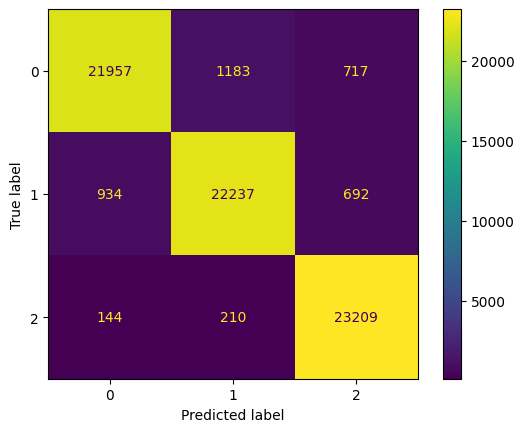

100%|██████████| 279/279 [00:23<00:00, 11.67it/s]


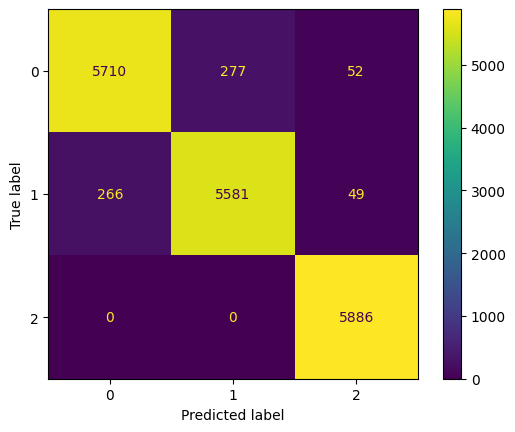

Epoch 11/20, Train Loss: 0.6052, Train F1: 0.9456,Test Loss: 0.5868, Test F1: 0.9639, 


100%|██████████| 1114/1114 [01:45<00:00, 10.60it/s]


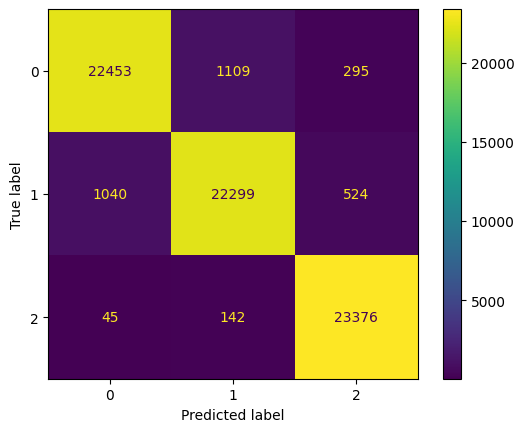

100%|██████████| 279/279 [00:23<00:00, 12.07it/s]


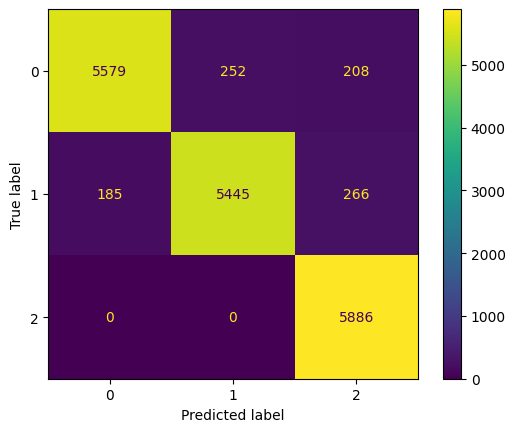

Epoch 12/20, Train Loss: 0.5949, Train F1: 0.9557,Test Loss: 0.6018, Test F1: 0.9488, 


100%|██████████| 1114/1114 [01:45<00:00, 10.58it/s]


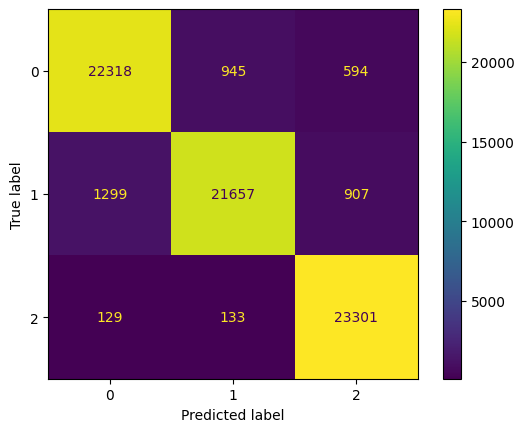

100%|██████████| 279/279 [00:23<00:00, 12.07it/s]


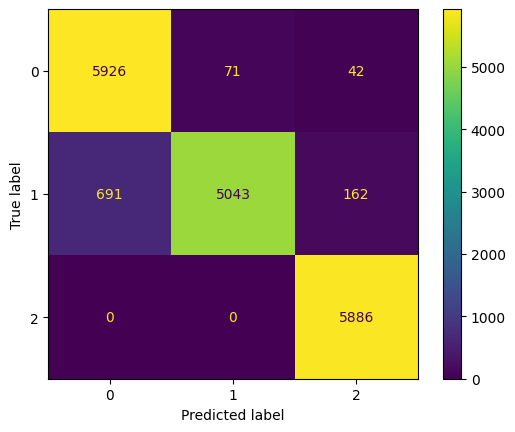

Epoch 13/20, Train Loss: 0.6067, Train F1: 0.9438,Test Loss: 0.6042, Test F1: 0.9458, 


100%|██████████| 1114/1114 [01:46<00:00, 10.47it/s]


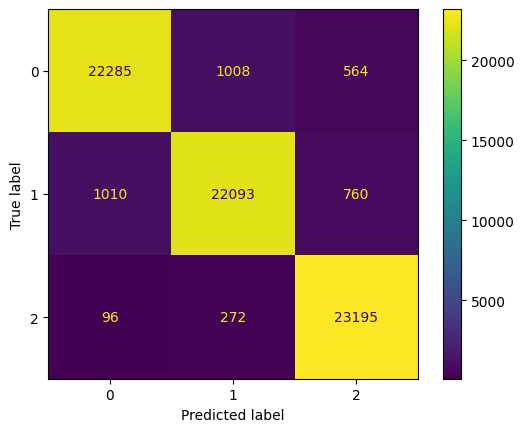

100%|██████████| 279/279 [00:23<00:00, 11.70it/s]


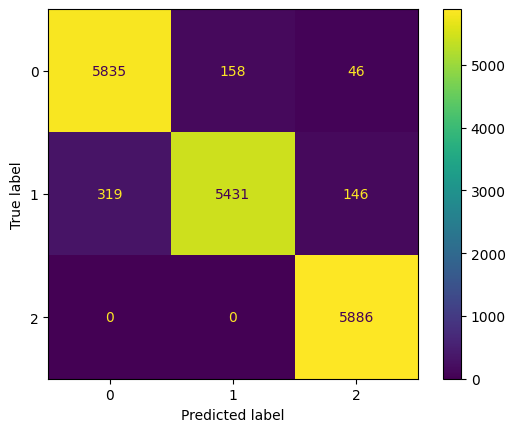

Epoch 14/20, Train Loss: 0.6026, Train F1: 0.9480,Test Loss: 0.5879, Test F1: 0.9625, 


100%|██████████| 1114/1114 [01:44<00:00, 10.70it/s]


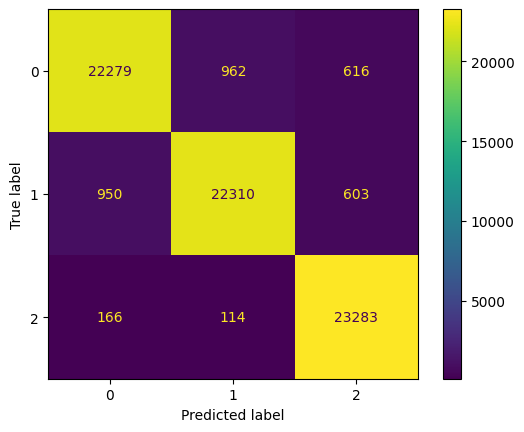

100%|██████████| 279/279 [00:23<00:00, 11.73it/s]


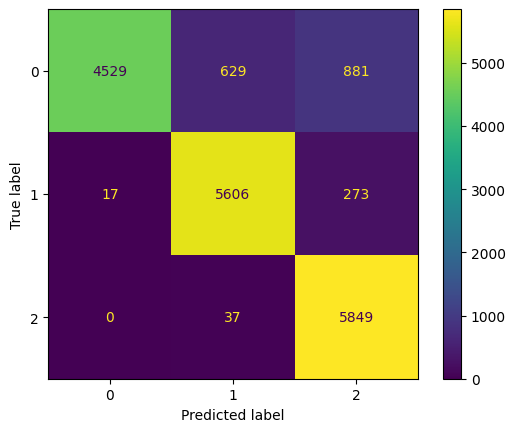

Epoch 15/20, Train Loss: 0.5986, Train F1: 0.9521,Test Loss: 0.6533, Test F1: 0.8969, 


100%|██████████| 1114/1114 [01:45<00:00, 10.60it/s]


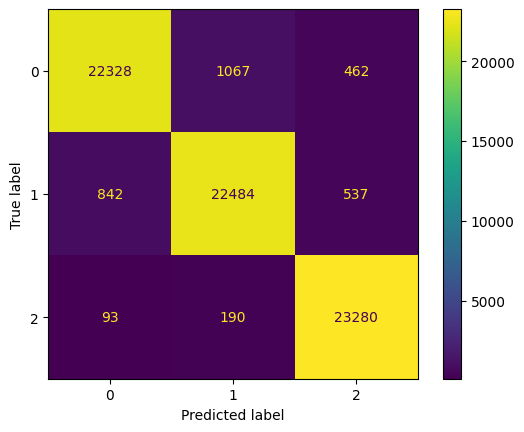

100%|██████████| 279/279 [00:23<00:00, 11.69it/s]


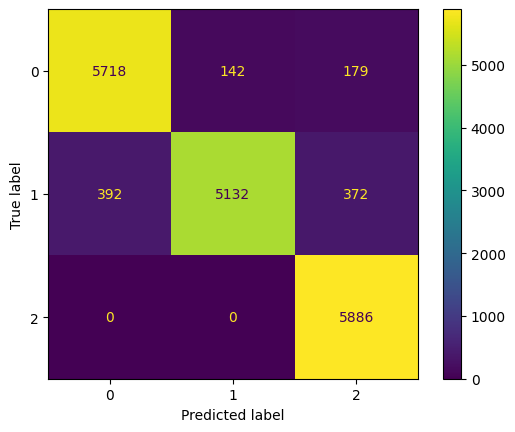

Epoch 16/20, Train Loss: 0.5955, Train F1: 0.9552,Test Loss: 0.6116, Test F1: 0.9390, 


100%|██████████| 1114/1114 [01:45<00:00, 10.53it/s]


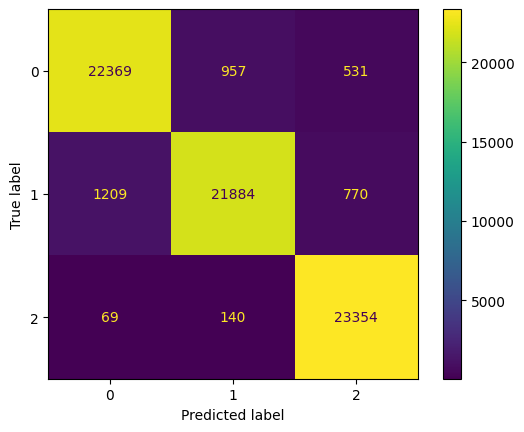

100%|██████████| 279/279 [00:23<00:00, 11.72it/s]


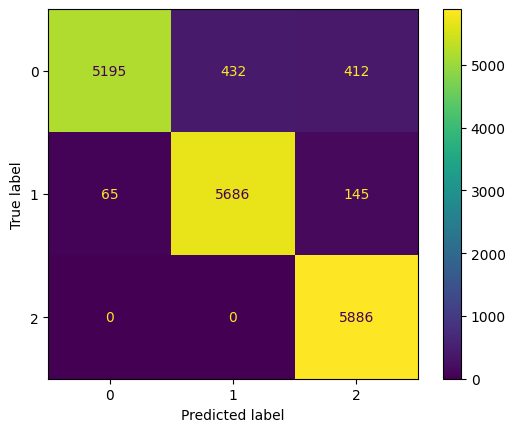

Epoch 17/20, Train Loss: 0.6023, Train F1: 0.9484,Test Loss: 0.6101, Test F1: 0.9408, 


100%|██████████| 1114/1114 [01:43<00:00, 10.75it/s]


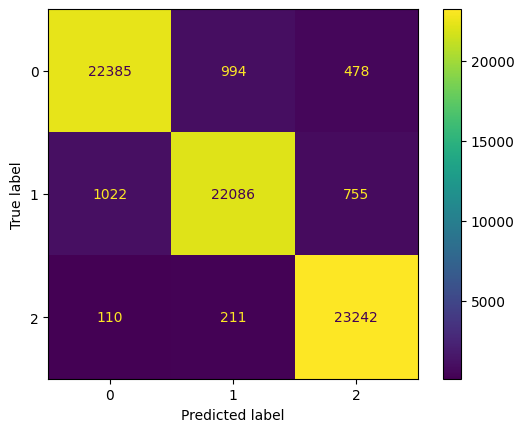

100%|██████████| 279/279 [00:23<00:00, 12.05it/s]


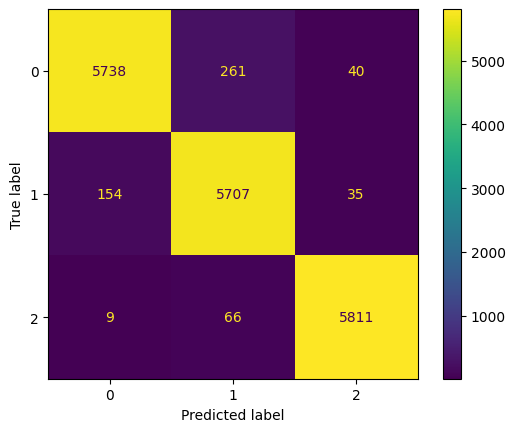

Epoch 18/20, Train Loss: 0.6005, Train F1: 0.9499,Test Loss: 0.5829, Test F1: 0.9682, 


100%|██████████| 1114/1114 [01:47<00:00, 10.40it/s]


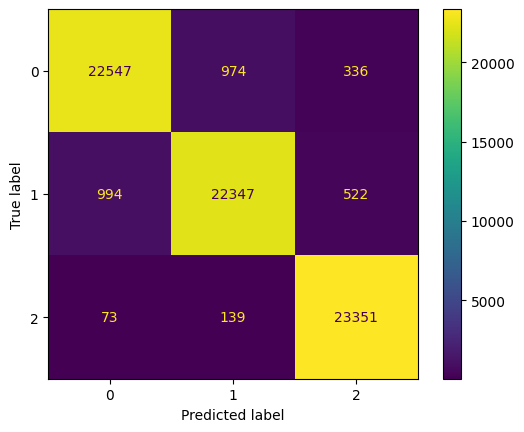

100%|██████████| 279/279 [00:23<00:00, 11.98it/s]


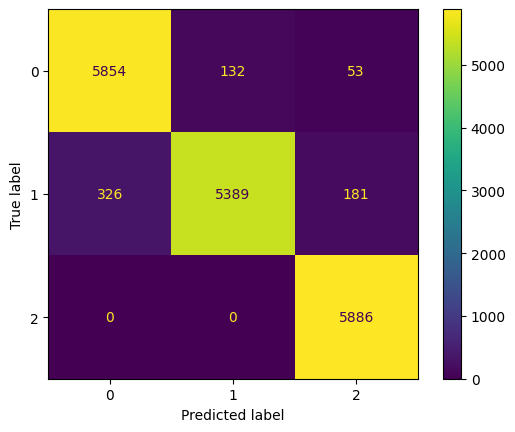

Epoch 19/20, Train Loss: 0.5936, Train F1: 0.9574,Test Loss: 0.5895, Test F1: 0.9612, 


In [41]:
mean_loss_train_lens,mean_f1_train_lens,mean_loss_test_lens,mean_f1_test_lens = train_final_model(lens,train_looader,test_looader,n_epochs=CONFIG.epochs,optimizer=optimizer,criterion=criterion,device=device,model_name = "lensiformer")

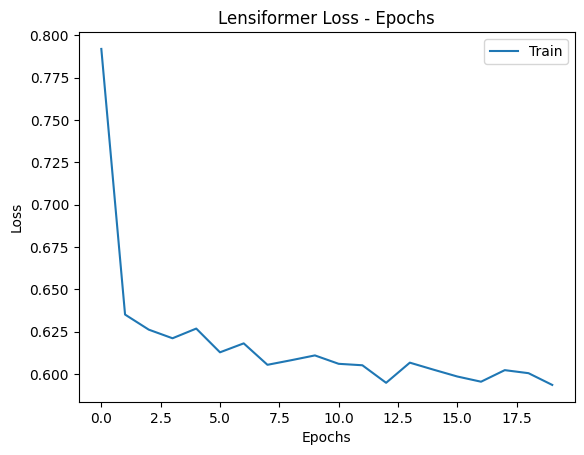

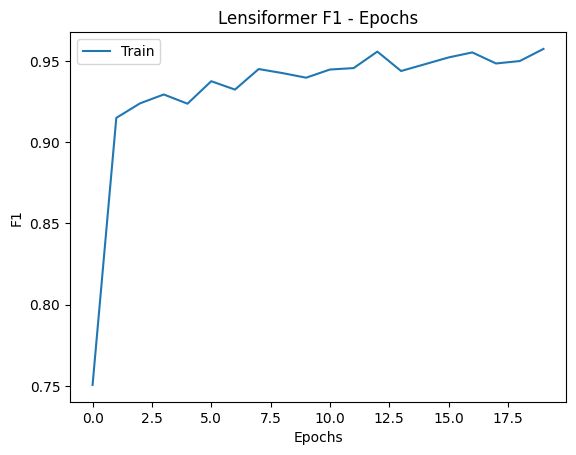

In [42]:
plot_model_metrics(mean_loss_train_lens,mean_f1_train_lens,model_name = "Lensiformer",mode="Train")

# MY MODEL

The formula for the angular deflection for strong gravitational lensing is:

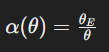
where theta is the angular distance, thetaE is the Einstein angle

**Approach:**
- The encoder encodes the Einstein angle .
- Instead of learning directly from the observed image, the network learns from the difference between the source and observed lensing images since The goal is to classify dark matter substructures responsible for these changes.


# THE BASIC ARCHITECTURE IS 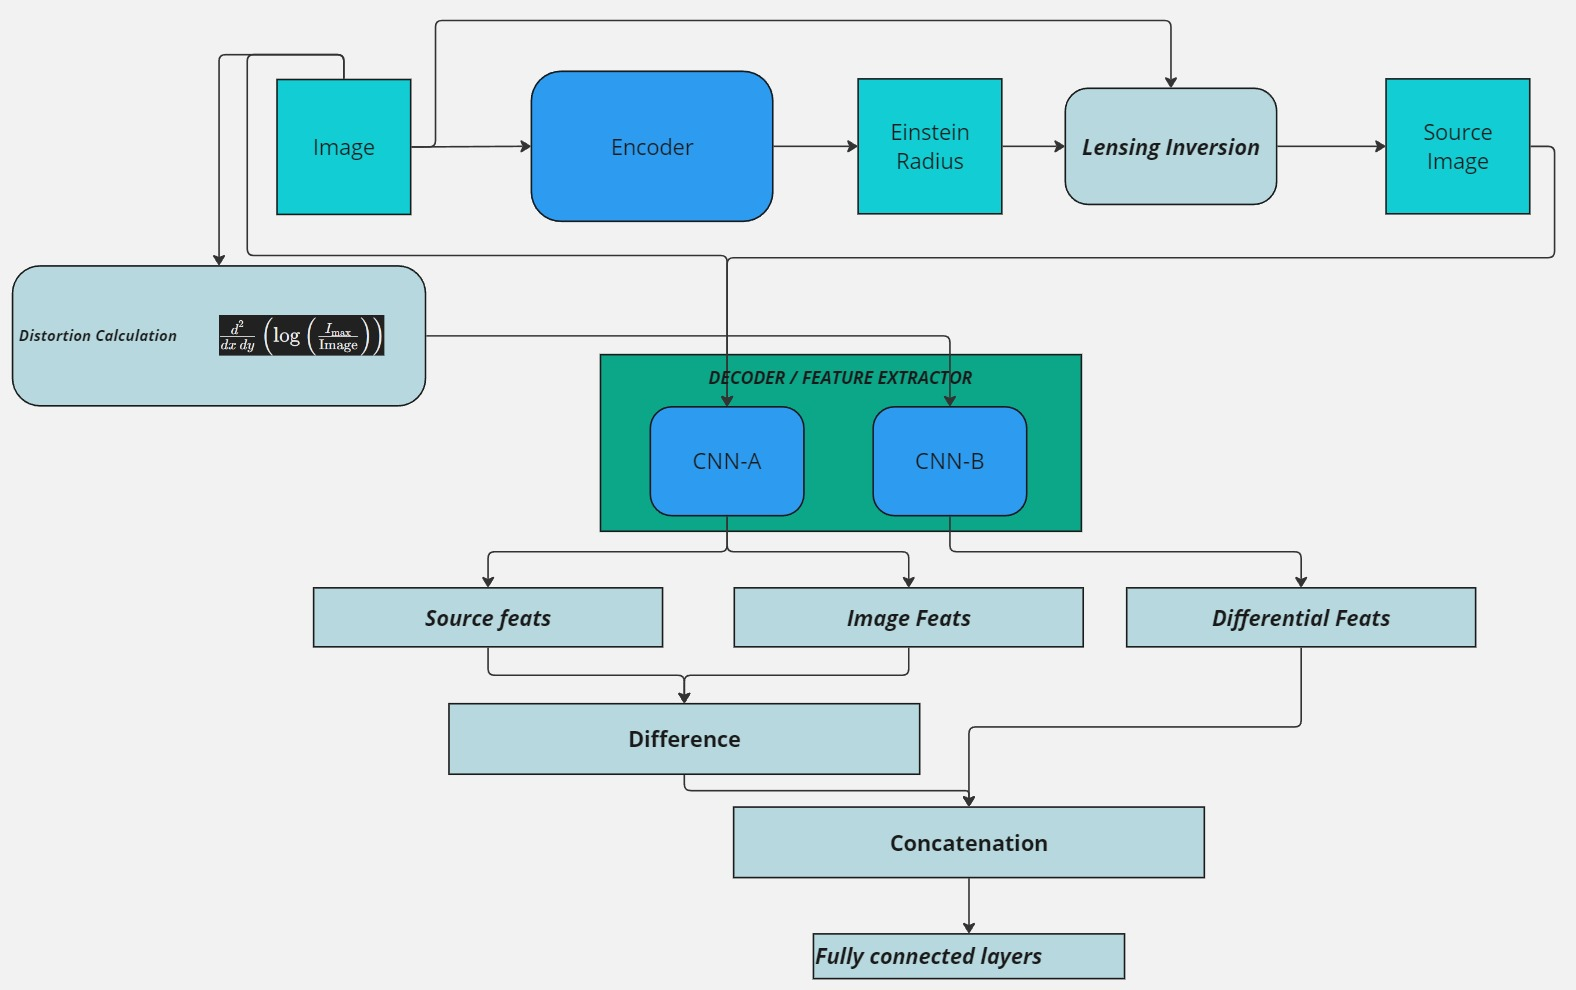

In [43]:
class ChangedPhysicsInformedEncoder(nn.Module):
    def __init__(self, image_size, patch_size, embedding_dim, num_patches, num_heads,
                 hidden_dim, transformer_block_activation_function, num_transformer_block,
                 device: torch.device, k_max, k_min, num_hidden_layer=1, dropout=0.1, pixel_scale=0.101,
                 min_angle=-3.323, max_angle=3.232, mag=1):
        super().__init__()

        self.image_size = image_size
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.num_patches = num_patches
        self.num_heads = num_heads
        self.hidden_dim = hidden_dim
        self.k_max = k_max
        self.k_min = k_min
        self.transformer_block_activation_function = transformer_block_activation_function
        self.num_transformer_block = num_transformer_block
        self.device = device
        self.dropout = dropout
        self.pixel_scale = pixel_scale
        self.min_angle = min_angle
        self.max_angle = max_angle
        self.source_mag = mag

        self.transformer = nn.ModuleList()

        for _ in range(self.num_transformer_block):
            self.transformer.append(
                TransformerLSABlock(embedding_dim=self.embedding_dim,
                                    num_head=self.num_heads,
                                    num_patches=self.num_patches,
                                    num_hidden_neurons=self.hidden_dim,
                                    num_hidden_layers=num_hidden_layer,
                                    activation_function=self.transformer_block_activation_function,
                                    device=self.device,
                                    dropout=dropout)
            )

        # Adding a compressor to give us the deflection angle for each pixel
        self.transformer.append(nn.Flatten())
        self.total_features = (self.num_patches + 1) * self.embedding_dim
        self.transformer.append(nn.Linear(self.total_features, 1))
        self.physics = Physics(mag=1)
        self.imones = torch.ones((self.image_size,self.image_size)).to(self.device)
        self.imones_1d = torch.ones((self.image_size*self.image_size)).to(self.device)
        # Create a grid for image coordinates
        self.profile_size = self.image_size
        self.half_profile_size = self.profile_size // 2

    def image_to_source(self, image, centre=None, E_r=None, deflection=None, gradient=None):
        length, width = image.shape
        pixel_width = (self.max_angle - self.min_angle) / length
        if centre is None:
            centre = (length // 2, width // 2)
        centre_x, centre_y = centre
        if False:
            centre_x = centre_x.item()
            centre_y = centre_y.item()
        
        range_indices_x = torch.arange(-(centre_x - 1), length - (centre_x - 1), device=self.device)
        range_indices_y = torch.arange(-(centre_y - 1), width - (centre_y - 1), device=self.device)

        x, y = torch.meshgrid(range_indices_x, range_indices_y, indexing='ij')
        x, y = x * pixel_width, y * pixel_width

        r = torch.sqrt(x**2 + y**2)
        mask = (r == 0)
        r[mask] = 1

        if deflection is not None:
            if deflection.shape != (length, width):
                raise ValueError(f"The deflection should be of shape (2, {length}, {width}) but got {deflection.shape}")
            xdef = (deflection * x) / r
            ydef = (deflection * y) / r
        elif gradient is not None:
            if gradient.shape != image.shape:
                raise ValueError("The gradient and image should be of the same shape")
            xdef = np.gradient(gradient, axis=0)
            ydef = np.gradient(gradient, axis=1)
        elif E_r is not None:
            k = torch.ones((length, width), device=self.device) * E_r
            xdef = (k * x) / r
            ydef = (k * y) / r
        else:
            raise ValueError("Both deflection and gradient cannot be None")

        bx = x - xdef
        by = y - ydef

        bx, by = bx / pixel_width, by / pixel_width

        bx = torch.clamp(bx + centre_x * self.source_mag, 0, length * self.source_mag - 1).long()
        by = torch.clamp(by + centre_y * self.source_mag, 0, width * self.source_mag - 1).long()

        # Initialize the output image tensor
        sourceimage = torch.zeros((length * self.source_mag, width * self.source_mag), dtype=torch.float, device=self.device)
        
        # Flatten the image and coordinates
        flat_image = image.view(-1)
        flat_bx = bx.view(-1)
        flat_by = by.view(-1)

        # Calculate 1D indices
        one_d_indices = flat_bx * (width * self.source_mag) + flat_by

        # Scatter add the values to sourceimage
        sourceimage_flat = sourceimage.view(-1)
        count  = torch.zeros_like(sourceimage_flat)
        sourceimage_flat = sourceimage_flat.scatter_add(0, one_d_indices, flat_image)
        count = count.scatter_add(0, one_d_indices, self.imones_1d)
        mask = count!=0
        sourceimage_flat[mask]/=count[mask]
        sourceimage = sourceimage_flat.view(sourceimage.shape)

        return sourceimage


    def forward(self, input_images, patches,distortion):
        # Move tensors to the appropriate device
        input_images = input_images.to(self.device)
        distortion = distortion.to(self.device)
        patches = patches.to(self.device)

        batch_size = input_images.shape[0]

        # Process patches through transformer layers
        k_sigmoid = patches
        for layer in self.transformer:
            k_sigmoid = layer(k_sigmoid)

        # Extract output components from k_sigmoid
        distortion = distortion.view(batch_size,self.image_size,self.image_size)
        einstein_angle = k_sigmoid

        # Reshape input images
        input_images = input_images.view(batch_size, self.image_size, self.image_size)

        # Initialize source_image tensor
        source_image = torch.zeros_like(input_images)

        # Transform each image in the batch
        for i in range(batch_size):
            source_image_np = self.image_to_source(image=input_images[i], E_r=einstein_angle[i])
            source_image[i] = source_image_np

        return k_sigmoid,source_image


In [44]:
class Decoder(nn.Module):
    def __init__(self,
                 image_size: int,
                 patch_size: int,
                 embed_dim: int,
                 in_channels: int,
                 num_classes: int,
                 num_heads: int,
                 num_hidden_neurons: int,
                 num_hidden_layers: int,
                 transformer_activation: nn.Module,
                 feedforward_activation: nn.Module,
                 num_transformer_blocks: int,
                 device: torch.device,
                 dropout_rate: float = 0.1):
        """
        Initializes Lensiformer, a Relativistic Physics-Informed Vision Transformer (PIViT) Architecture for Dark Matter Morphology.

        Args:
            image_size (int): Size of the input image (assumed square).
            patch_size (int): Size of each image patch (assumed square).
            embed_dim (int): Dimension of the embedding space.
            in_channels (int): Number of input channels.
            num_classes (int): Number of target classes.
            num_heads (int): Number of attention heads.
            num_hidden_neurons (int): Number of neurons in hidden layers.
            num_hidden_layers (int): Number of hidden layers.
            transformer_activation (nn.Module): Activation function for transformer blocks.
            feedforward_activation (nn.Module): Activation function for feedforward layers.
            num_transformer_blocks (int): Number of transformer blocks.
            device (torch.device): Computational device (CPU/GPU).
            dropout_rate (float, optional): Dropout rate. Defaults to 0.1.
        """
        super(Decoder, self).__init__()

        # Initialize parameters
        self.image_size = image_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.num_heads = num_heads
        self.num_hidden_neurons = num_hidden_neurons
        self.num_hidden_layers = num_hidden_layers
        self.transformer_activation = transformer_activation
        self.feedforward_activation = feedforward_activation
        self.num_transformer_blocks = num_transformer_blocks
        self.device = device
        self.dropout_rate = dropout_rate

        # Initialize modules
        self.initial_tokenizer = ShiftPatchTokenizer(image_size=image_size, embedding_size=embed_dim, patch_size=patch_size, num_channels=in_channels, translation_mode="diagonal", device=device)
        """self.secondary_tokenizer = ShiftPatchTokenizer(image_size=image_size, embedding_size=embed_dim, patch_size=patch_size, num_channels=in_channels, translation_mode="diagonal", device=device)
        self.tertiary_tokenizer = ShiftPatchTokenizer(image_size=image_size, embedding_size=embed_dim, patch_size=patch_size, num_channels=in_channels, translation_mode="diagonal", device=device)"""
        self.encoder = ChangedPhysicsInformedEncoder(image_size=image_size, 
                                              patch_size=patch_size, 
                                              embedding_dim = embed_dim, 
                                              num_patches = self.initial_tokenizer.get_num_patches(), 
                                              num_heads=num_heads,
                                              hidden_dim=num_hidden_neurons, 
                                              transformer_block_activation_function=feedforward_activation, 
                                              num_transformer_block = num_transformer_blocks,
                                              device = device, 
                                              k_max = 1.2, 
                                              k_min = 0.8)

        # Transformer blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerLSABlock(embedding_dim = embed_dim,
                                num_head = num_heads,
                                num_patches = self.initial_tokenizer.get_num_patches(),
                                num_hidden_neurons=num_hidden_neurons,
                                num_hidden_layers=1,
                                activation_function=transformer_activation,
                                device=device)
            for _ in range(num_transformer_blocks)
        ])

        # Flatten and FeedForward layers
        self.flatten_layer = Flatten((self.initial_tokenizer.get_num_patches() + 1) * embed_dim)

        self.decoder1 = timm.create_model("efficientnet_b0",pretrained = True)
        self.decoder1.conv_stem = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        self.decoder2 = timm.create_model("efficientnet_b0",pretrained = True)
        self.decoder2.conv_stem = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        self.fc = nn.Linear(1000*2,num_classes)
        
    def invert_lens(self, images: torch.Tensor) -> torch.Tensor:
        batch_size = images.size(0)
        images_T = images.reshape(batch_size, 1, self.image_size, self.image_size)
        # Tokenize input images into patches
        initial_patches = self.initial_tokenizer(images_T)

        # Encode images and patches
        lens_corrected_images = self.encoder(images, initial_patches)

        return lens_corrected_images

    def forward(self, images: torch.Tensor,distortions) -> torch.Tensor:
        """
        Forward pass through the Physics-Informed Vision Transformer.

        Args:
            images (Tensor): Input images with shape (batch_size, channels, height, width).

        Returns:
            Tensor: Model predictions with shape (batch_size, num_classes).
        """
        images = images.to(self.device)
        distortions = distortions.to(self.device)
        batch_size = images.size(0)
        distortions = distortions.view(batch_size,1,self.image_size,self.image_size)

        # Tokenize input images into patches
        initial_patches = self.initial_tokenizer(images.reshape(batch_size, 1, self.image_size, self.image_size))
        
        info,lens_corrected_images = self.encoder(images, initial_patches,distortions)
        source = lens_corrected_images.view(batch_size,1,64,64)
        source = source.to(self.device)
        
        image_feats = self.decoder1(images)
        source_feats = self.decoder1(source)
        dis_feats = self.decoder2(distortions)
        
        # Pass through transformer blocks
        verbose = 2
        if verbose ==0:
            print("source_shape = ",source_patches.shape)
            print("observed_shape = ",initial_patches.shape)
            print("distortion_shape = ",dis_patches.shape)
            print("concat feats",concatenated.shape)

        """for block in self.transformer_blocks:
            dis_feats = block(key = dis_patches,value = dis_patches)
        #concatenated = torch.concat((dis_patches,source_feats,initial_patches),dim=2)
        # Flatten the patches"""
        concatenated = torch.concat((dis_feats-source_feats,image_feats),dim=1)
        #flattened_patches = self.flatten_layer(dis_feats)
        # Generate final predictions
        final_predictions = self.fc(concatenated)
        return info,source,final_predictions


In [45]:
model  = Decoder(image_size=64,
                    patch_size=32,
                    embed_dim=384,
                    in_channels=1,
                    num_classes=3,
                    num_heads=16,
                    num_hidden_neurons=64,
                    num_hidden_layers=1,
                    transformer_activation=nn.ELU,
                    feedforward_activation=nn.ELU,
                    num_transformer_blocks = 1,
                    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
                    ).to("cuda")


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [46]:
count_parameters(model)

+------------------------------------------------------+------------+
|                       Modules                        | Parameters |
+------------------------------------------------------+------------+
|          initial_tokenizer.class_embedding           |    384     |
|             initial_tokenizer.positional             |    1920    |
|          initial_tokenizer.tokenizer.weight          |  1966080   |
|           initial_tokenizer.tokenizer.bias           |    384     |
|          encoder.transformer.0.temperature           |     1      |
|    encoder.transformer.0.mlsa.mha.in_proj_weight     |   442368   |
|     encoder.transformer.0.mlsa.mha.in_proj_bias      |    1152    |
|    encoder.transformer.0.mlsa.mha.out_proj.weight    |   147456   |
|     encoder.transformer.0.mlsa.mha.out_proj.bias     |    384     |
|       encoder.transformer.0.first_norm.weight        |    384     |
|        encoder.transformer.0.first_norm.bias         |    384     |
| encoder.transforme

14437310

## this model has 14 million parameters 

In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-4)
model = model.to("cuda")

100%|██████████| 1114/1114 [04:17<00:00,  4.33it/s]


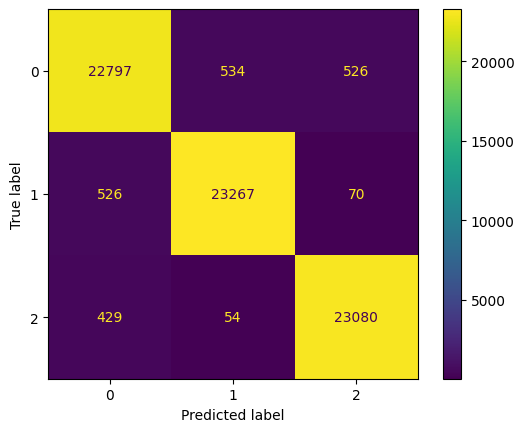

100%|██████████| 279/279 [00:31<00:00,  8.80it/s]


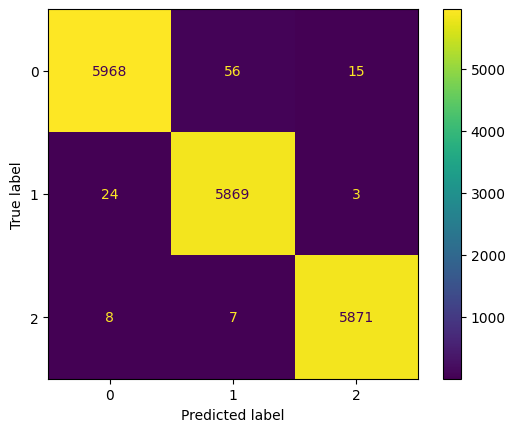

Epoch 0/20, Train Loss: 0.0829, Train F1: 0.9700,Test Loss: 0.1336, Test F1: 0.9936, 


100%|██████████| 1114/1114 [04:17<00:00,  4.33it/s]


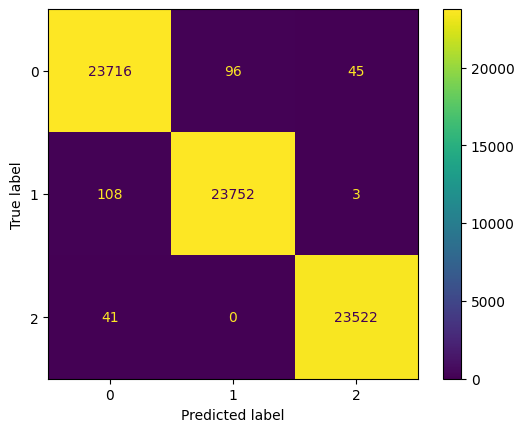

100%|██████████| 279/279 [00:32<00:00,  8.65it/s]


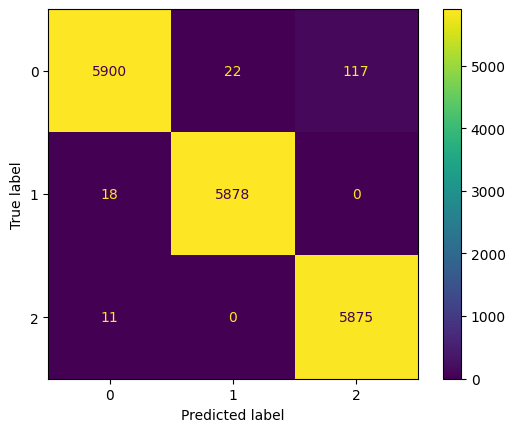

Epoch 1/20, Train Loss: 0.0132, Train F1: 0.9959,Test Loss: 0.0341, Test F1: 0.9905, 


100%|██████████| 1114/1114 [04:15<00:00,  4.36it/s]


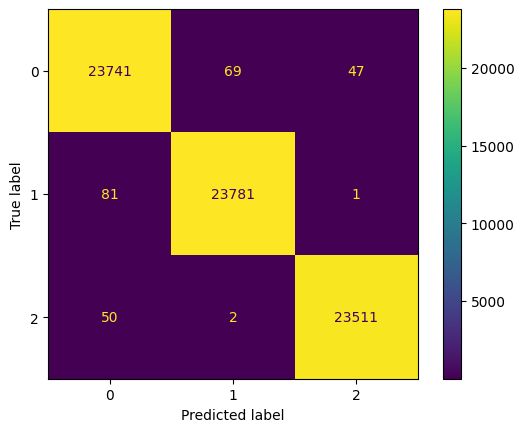

100%|██████████| 279/279 [00:31<00:00,  8.95it/s]


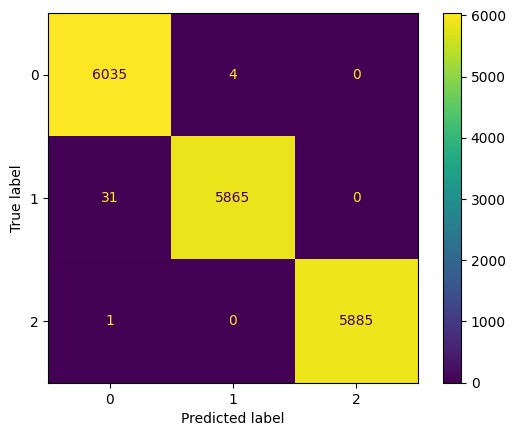

Epoch 2/20, Train Loss: 0.0116, Train F1: 0.9965,Test Loss: 0.0101, Test F1: 0.9980, 


100%|██████████| 1114/1114 [04:16<00:00,  4.35it/s]


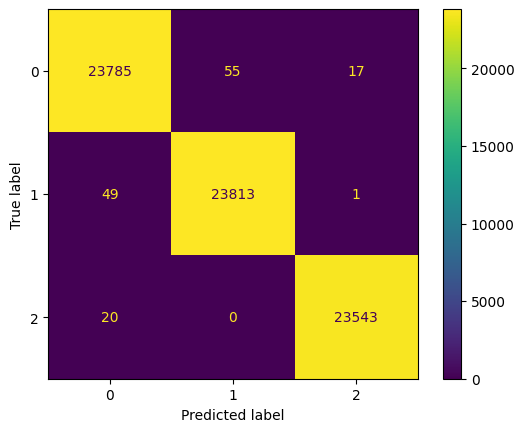

100%|██████████| 279/279 [00:30<00:00,  9.06it/s]


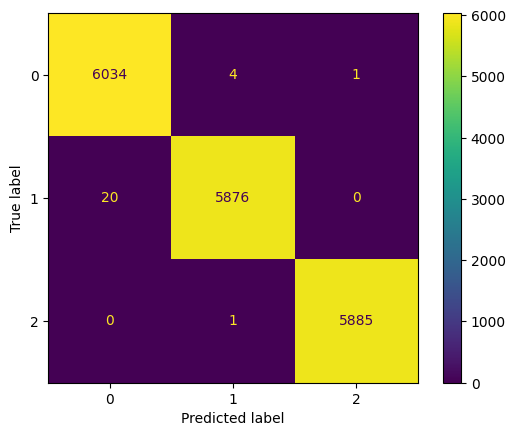

Epoch 3/20, Train Loss: 0.0070, Train F1: 0.9980,Test Loss: 0.0051, Test F1: 0.9985, 


100%|██████████| 1114/1114 [04:15<00:00,  4.36it/s]


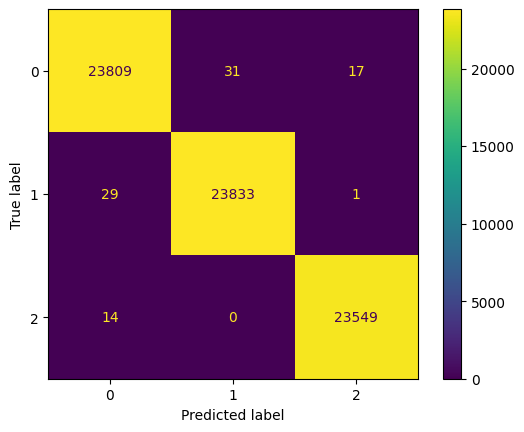

100%|██████████| 279/279 [00:30<00:00,  9.03it/s]


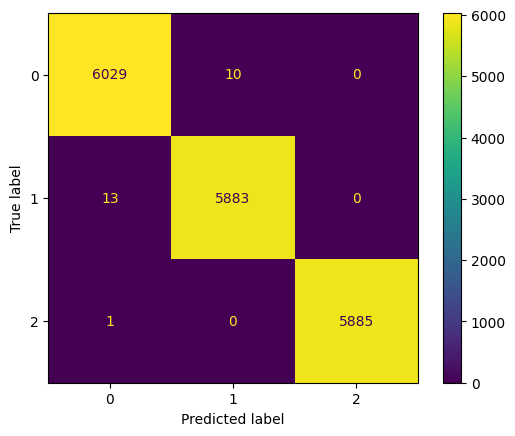

Epoch 4/20, Train Loss: 0.0052, Train F1: 0.9987,Test Loss: 0.0052, Test F1: 0.9987, 


100%|██████████| 1114/1114 [04:19<00:00,  4.30it/s]


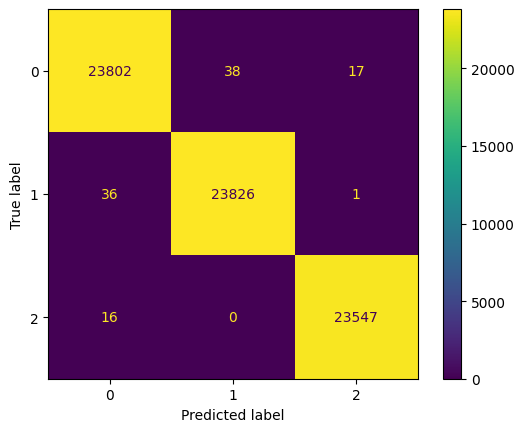

100%|██████████| 279/279 [00:31<00:00,  8.91it/s]


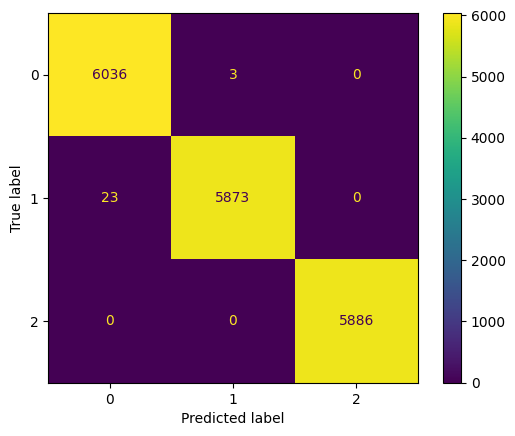

Epoch 5/20, Train Loss: 0.0051, Train F1: 0.9985,Test Loss: 0.0066, Test F1: 0.9985, 


100%|██████████| 1114/1114 [04:17<00:00,  4.33it/s]


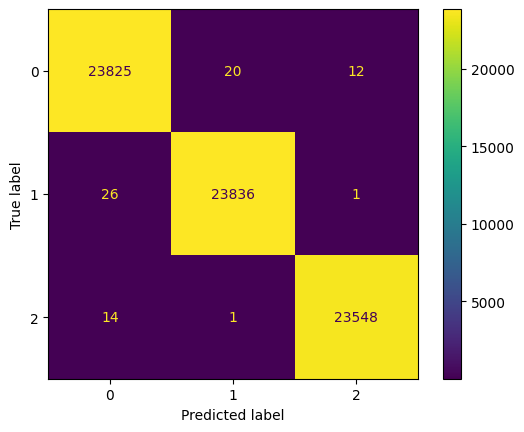

100%|██████████| 279/279 [00:31<00:00,  8.92it/s]


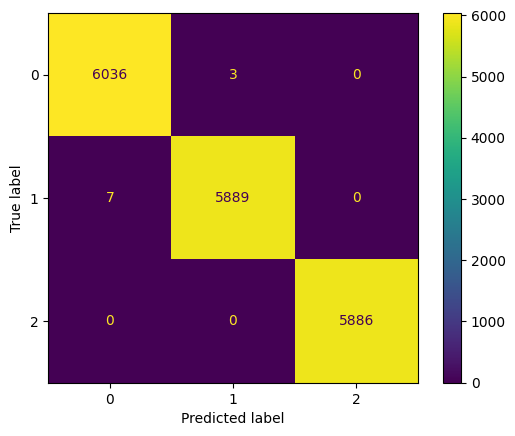

Epoch 6/20, Train Loss: 0.0041, Train F1: 0.9990,Test Loss: 0.0015, Test F1: 0.9994, 


100%|██████████| 1114/1114 [04:17<00:00,  4.32it/s]


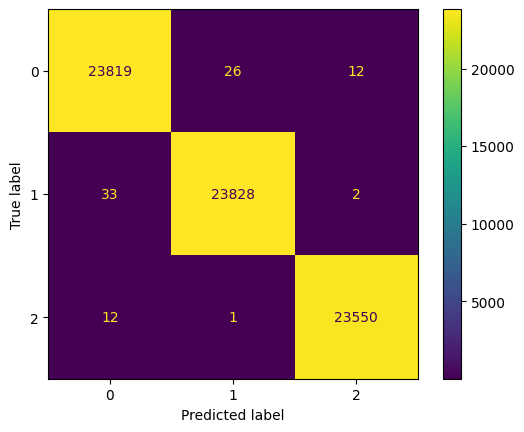

100%|██████████| 279/279 [00:31<00:00,  8.93it/s]


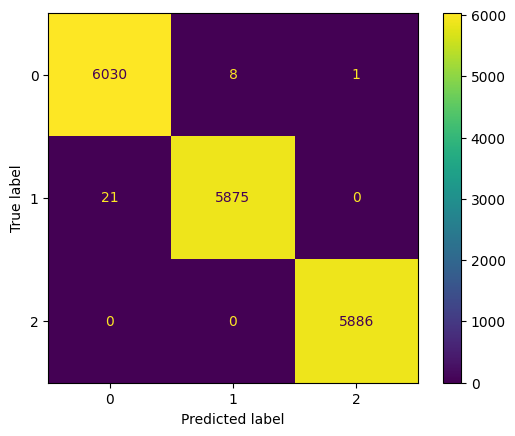

Epoch 7/20, Train Loss: 0.0051, Train F1: 0.9988,Test Loss: 0.0051, Test F1: 0.9983, 


100%|██████████| 1114/1114 [04:15<00:00,  4.35it/s]


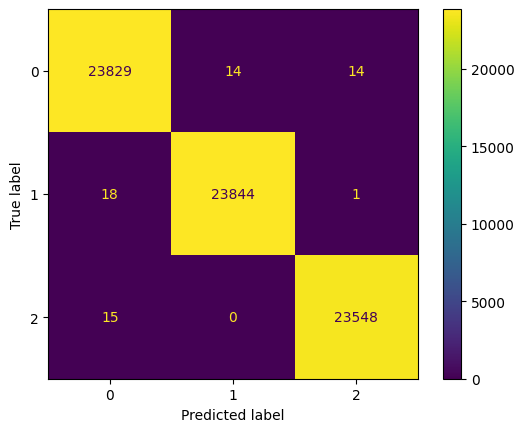

100%|██████████| 279/279 [00:31<00:00,  8.86it/s]


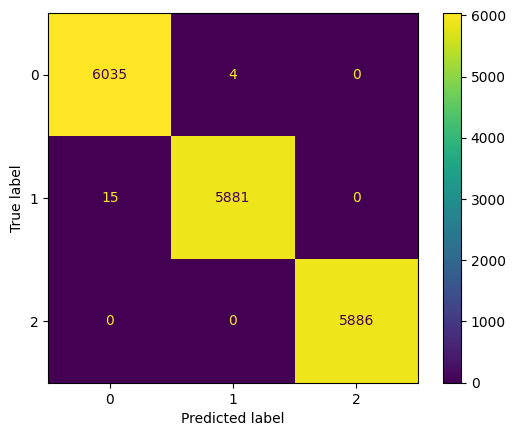

Epoch 8/20, Train Loss: 0.0032, Train F1: 0.9991,Test Loss: 0.0055, Test F1: 0.9989, 


100%|██████████| 1114/1114 [04:15<00:00,  4.36it/s]


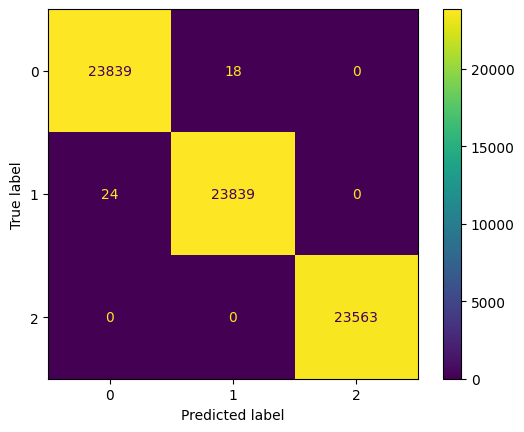

100%|██████████| 279/279 [00:30<00:00,  9.05it/s]


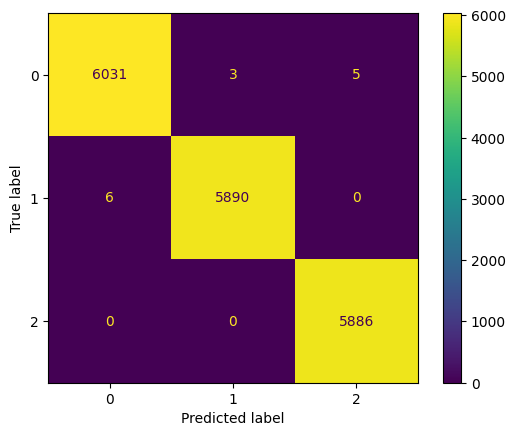

Epoch 9/20, Train Loss: 0.0020, Train F1: 0.9994,Test Loss: 0.0028, Test F1: 0.9992, 


100%|██████████| 1114/1114 [04:16<00:00,  4.33it/s]


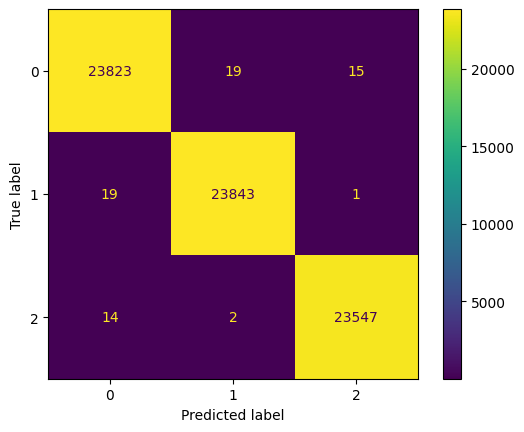

100%|██████████| 279/279 [00:30<00:00,  9.04it/s]


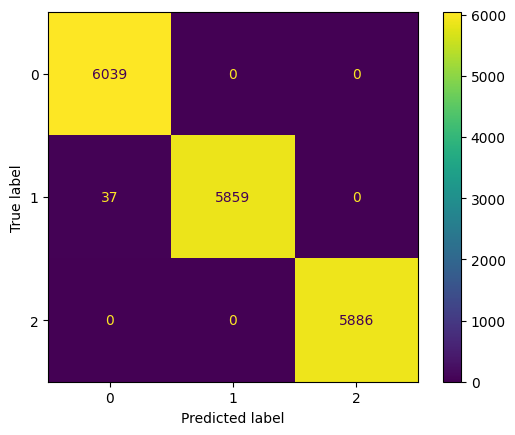

Epoch 10/20, Train Loss: 0.0033, Train F1: 0.9990,Test Loss: 0.0095, Test F1: 0.9979, 


100%|██████████| 1114/1114 [04:17<00:00,  4.33it/s]


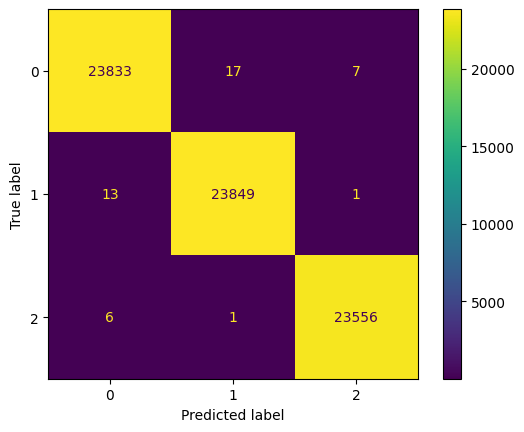

100%|██████████| 279/279 [00:31<00:00,  8.94it/s]


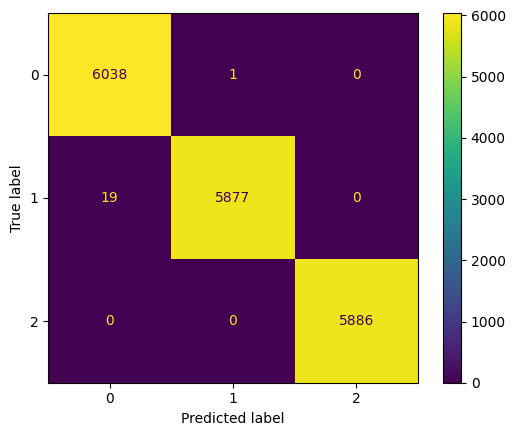

Epoch 11/20, Train Loss: 0.0020, Train F1: 0.9994,Test Loss: 0.0034, Test F1: 0.9989, 


100%|██████████| 1114/1114 [04:19<00:00,  4.30it/s]


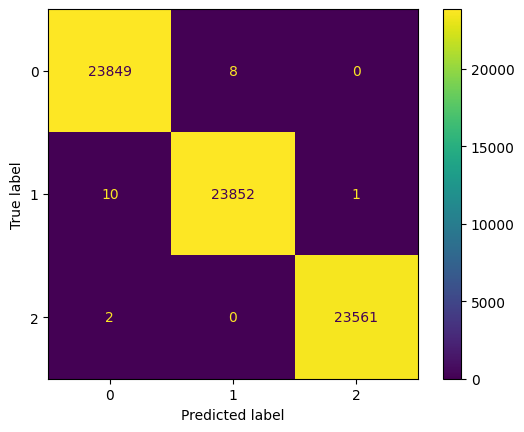

100%|██████████| 279/279 [00:31<00:00,  8.76it/s]


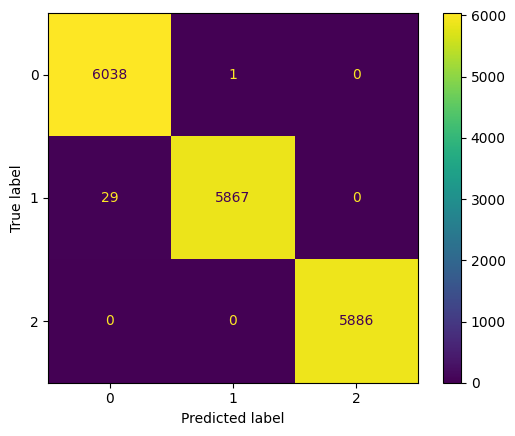

Epoch 12/20, Train Loss: 0.0012, Train F1: 0.9997,Test Loss: 0.0090, Test F1: 0.9983, 


100%|██████████| 1114/1114 [04:17<00:00,  4.33it/s]


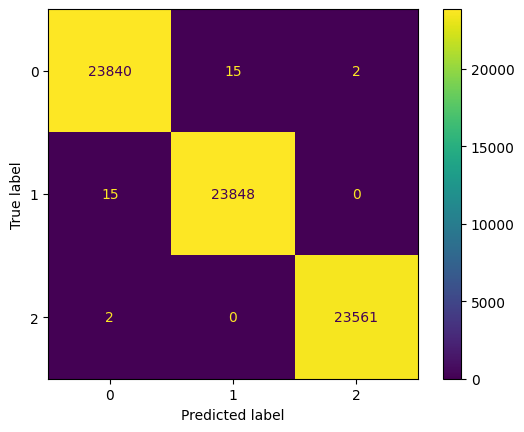

100%|██████████| 279/279 [00:31<00:00,  8.90it/s]


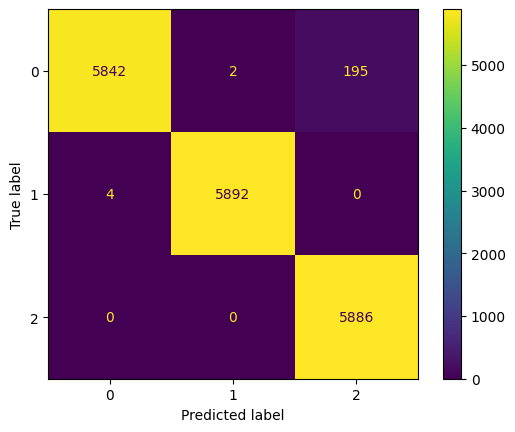

Epoch 13/20, Train Loss: 0.0017, Train F1: 0.9995,Test Loss: 0.0657, Test F1: 0.9887, 


100%|██████████| 1114/1114 [04:16<00:00,  4.34it/s]


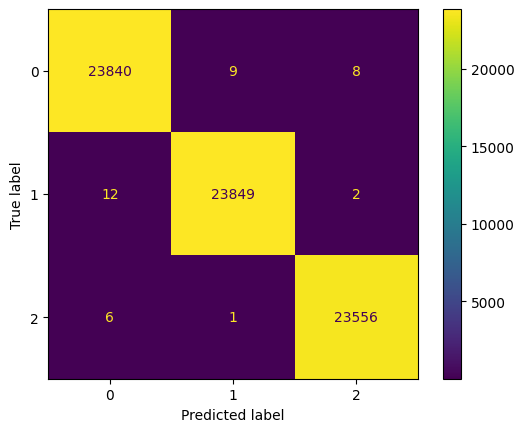

100%|██████████| 279/279 [00:31<00:00,  8.89it/s]


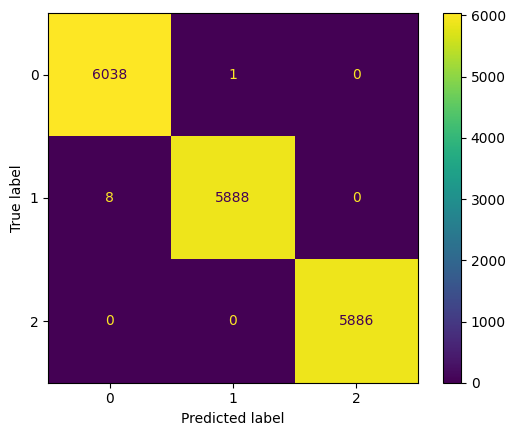

Epoch 14/20, Train Loss: 0.0020, Train F1: 0.9995,Test Loss: 0.0034, Test F1: 0.9995, 


100%|██████████| 1114/1114 [04:15<00:00,  4.35it/s]


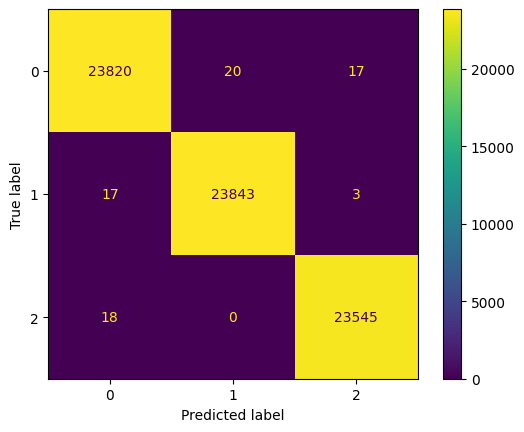

100%|██████████| 279/279 [00:30<00:00,  9.18it/s]


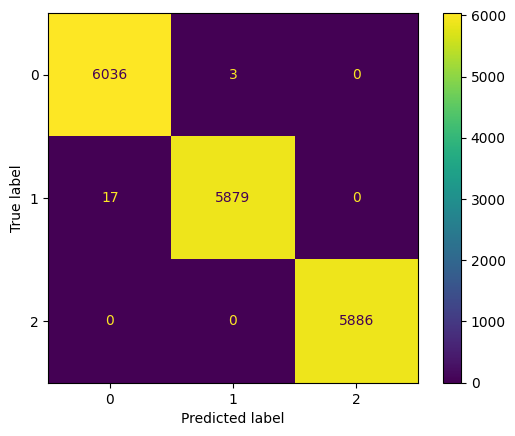

Epoch 15/20, Train Loss: 0.0036, Train F1: 0.9989,Test Loss: 0.0070, Test F1: 0.9989, 


100%|██████████| 1114/1114 [04:13<00:00,  4.39it/s]


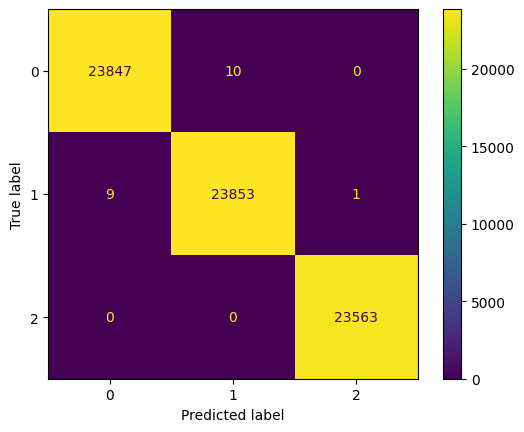

100%|██████████| 279/279 [00:30<00:00,  9.13it/s]


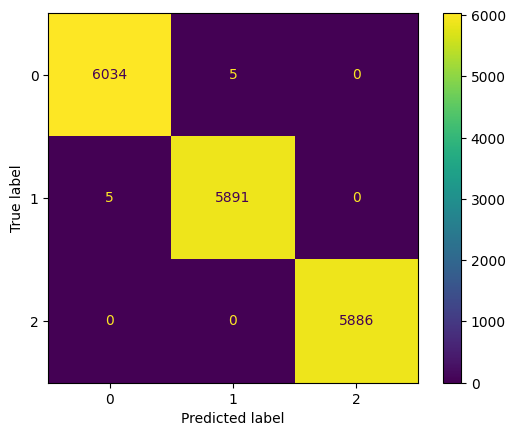

Epoch 16/20, Train Loss: 0.0009, Train F1: 0.9997,Test Loss: 0.0015, Test F1: 0.9994, 


100%|██████████| 1114/1114 [04:15<00:00,  4.37it/s]


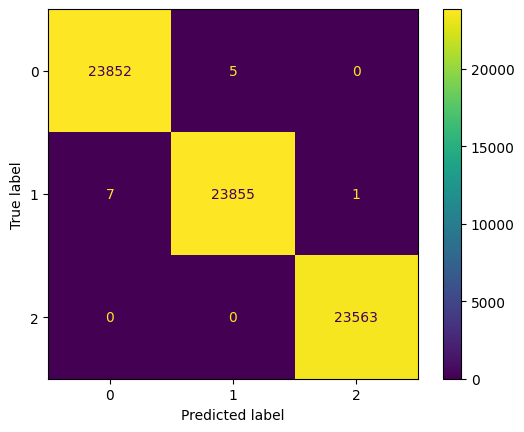

100%|██████████| 279/279 [00:31<00:00,  8.94it/s]


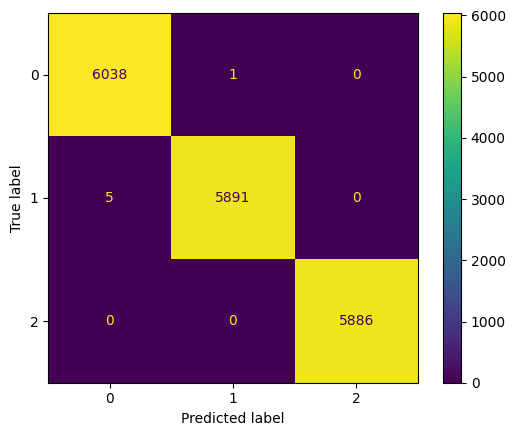

Epoch 17/20, Train Loss: 0.0010, Train F1: 0.9998,Test Loss: 0.0008, Test F1: 0.9997, 


100%|██████████| 1114/1114 [04:10<00:00,  4.44it/s]


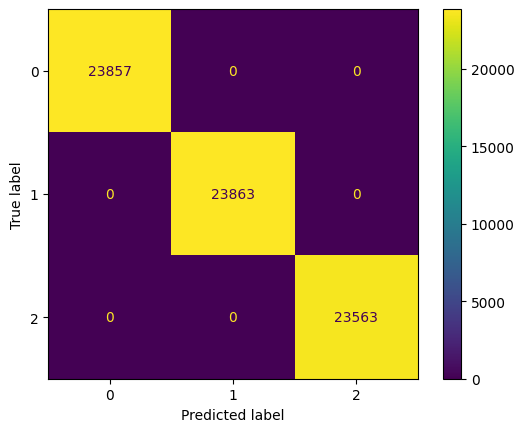

100%|██████████| 279/279 [00:28<00:00,  9.65it/s]


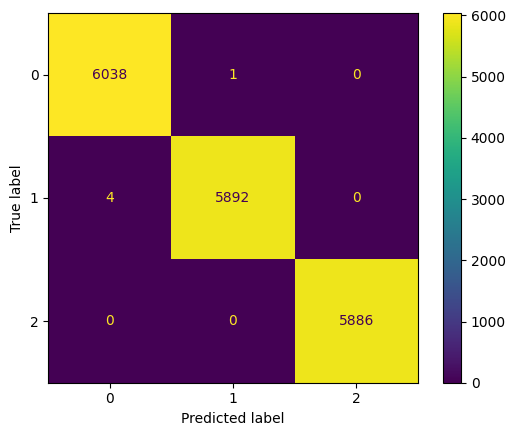

Epoch 18/20, Train Loss: 0.0000, Train F1: 1.0000,Test Loss: 0.0009, Test F1: 0.9997, 


100%|██████████| 1114/1114 [04:07<00:00,  4.51it/s]


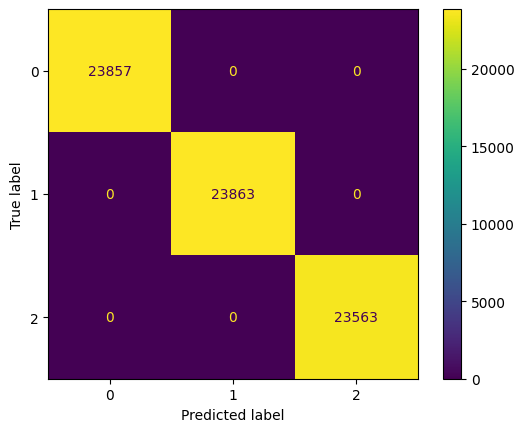

100%|██████████| 279/279 [00:29<00:00,  9.53it/s]


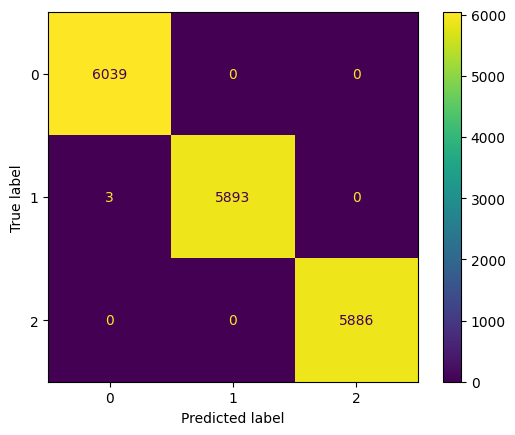

Epoch 19/20, Train Loss: 0.0000, Train F1: 1.0000,Test Loss: 0.0009, Test F1: 0.9998, 


In [48]:
mean_loss_train_model,mean_f1_train_model,mean_loss_test_model,mean_f1_test_model = train_final_model(model,train_looader,test_looader,n_epochs=CONFIG.epochs,optimizer=optimizer,criterion=criterion,device=device,model_name="new_model")

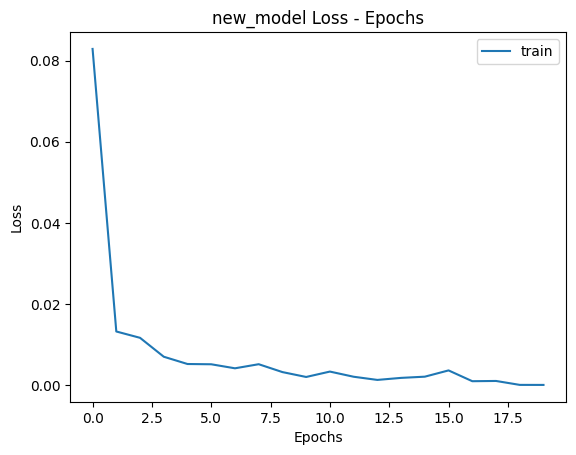

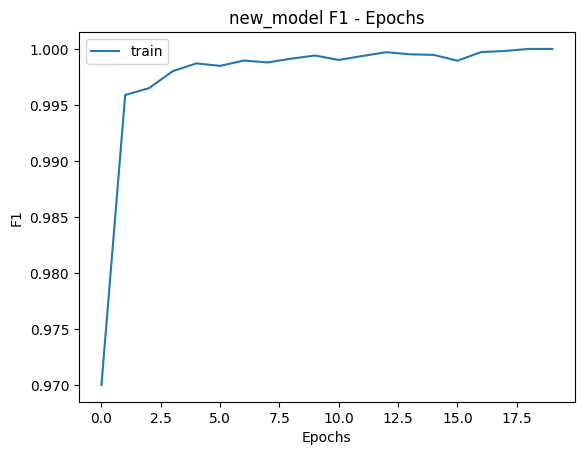

In [49]:
plot_model_metrics(mean_loss_train_model,mean_f1_train_model,model_name = "new_model",mode="train")

## ResNet

In [50]:
resnet = timm.create_model("resnet18",pretrained = True)
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet.fc = nn.Linear(512,3)

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [51]:
def train_final_model_other(model,total_training_loader,total_test_loader,n_epochs,optimizer,criterion,device,model_name):

    """

    Trains a PyTorch model.

    Args:

    - model (nn.Module): the PyTorch model to be trained
    - train_loader (DataLoader): DataLoader containing the training set
    - n_epochs (int): number of training epochs
    - optimizer (optim.Optimizer): the optimizer to use for training
    - criterion (nn.Module): the loss function to use for training
    - device (str): device to run the model on (e.g. 'cpu' or 'cuda')

    Returns:

    - mean_loss_train (list): mean loss per epoch for the training set
    - mean_auc_train (list): mean ROC-AUC per epoch for the test set


    """

    # initialize lists to keep track of metrics
    mean_loss_train = []
    mean_f1_train = []
    mean_loss_test = []
    mean_f1_test = []
    best_f1 = -2

    # loop over epochs
    for it in range(n_epochs):

        # initialize list to keep track of train loss for this epoch
        train_loss = []
        train_f1 = []
        y_true = []
        y_pred = []

        # set model to train mode
        model.train()

        # loop over training data
        for images,dis, targets in tqdm(total_training_loader):

            # move data to device
            images,dis, targets = images.to(device),dis.to(device), targets.to(device)
            batch = images.shape[0]
            images = images.view(batch,1,64,64)
            # zero the gradients
            optimizer.zero_grad()
            # forward pass
            outputs = model(images)
            # compute loss
            loss = criterion(outputs, targets)

            # backward pass and optimization step
            loss.backward()
            optimizer.step()
            #print("epochloss = ",loss)
            # append loss to train_loss list
            train_loss.append(loss.item())

            # ROC Score
            preds = outputs.detach().cpu().numpy()
            labels = targets.detach().cpu().numpy()

            preds = [np.argmax(pred) for pred in preds]
            y_true.append(labels)
            y_pred.append(preds)
            train_f1.append(f1_score(labels,preds,average='micro'))
            #print(train_f1)
        y_true = np.hstack(y_true).reshape(-1)
        y_pred = np.hstack(y_pred).reshape(-1)
        mat = confusion_matrix(y_true,y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=mat)
        disp.plot()
        plt.show()

        # initialize list to keep track of train loss for this epoch
        test_loss = []
        test_f1 = []

        # set model to train mode
        model.eval()
        y_true = []
        y_pred = []

        # turn off gradients for evaluation
        with torch.no_grad():

          # loop over training data
            for images,dis, targets in tqdm(total_test_loader):
                # move data to device
                images,dis, targets = images.to(device),dis.to(device), targets.to(device)
                batch = images.shape[0]
                images = images.view(batch,1,64,64)
                # forward pass
                #print(images.shape)
                outputs = model(images)

                # compute loss
                loss = criterion(outputs, targets)

                # append loss to train_loss list
                test_loss.append(loss.item())

                # ROC Score
                preds = outputs.detach().cpu().numpy()
                labels = targets.detach().cpu().numpy()


                preds = [np.argmax(pred) for pred in preds]
                y_true.append(labels)
                y_pred.append(preds)
                #print(labels)
                #print(preds)
                test_f1.append(f1_score(labels,preds,average='micro'))

            y_true = np.hstack(y_true).reshape(-1)
            y_pred = np.hstack(y_pred).reshape(-1)
            mat = confusion_matrix(y_true,y_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=mat)
            disp.plot()
            plt.show()


        # append the mean train loss for this epoch to the list of train losses
        mean_loss_train.append(np.mean(train_loss))
        mean_f1_train.append(np.mean(train_f1))
        mean_loss_test.append(np.mean(test_loss))
        mean_f1_test.append(np.mean(test_f1))

        if mean_f1_test[-1] > best_f1:
            best_f1 = mean_f1_test[-1]
            torch.save(model.state_dict(), "/kaggle/working/"+str(model_name)+"_best.pth")
            torch.save(model,"/kaggle/working/"+str(model_name)+"_complete.pth")


        # print epoch metrics
        print(f'Epoch {it}/{n_epochs}, Train Loss: {mean_loss_train[-1]:.4f}, Train F1: {mean_f1_train[-1]:.4f},Test Loss: {mean_loss_test[-1]:.4f}, Test F1: {mean_f1_test[-1]:.4f}, ')


    # return lists of mean train
    return mean_loss_train,mean_f1_train,mean_loss_test,mean_f1_test


In [52]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(resnet.parameters(),lr=1e-4)
resnet = resnet.to("cuda")

100%|██████████| 1114/1114 [00:45<00:00, 24.49it/s]


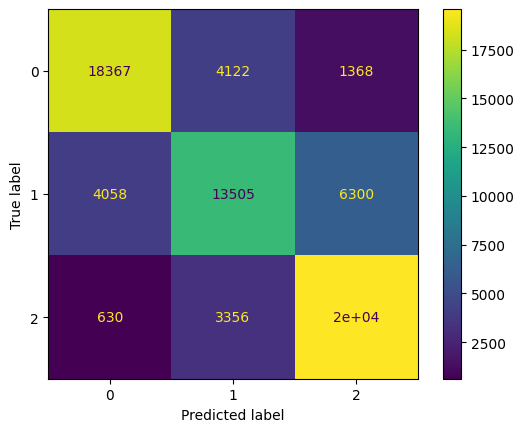

100%|██████████| 279/279 [00:06<00:00, 41.45it/s]


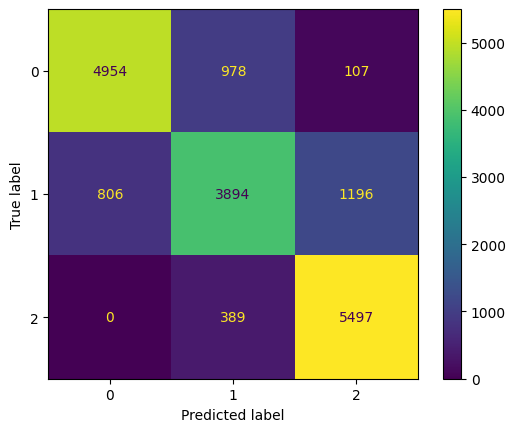

Epoch 0/20, Train Loss: 0.6449, Train F1: 0.7218,Test Loss: 0.4560, Test F1: 0.8048, 


100%|██████████| 1114/1114 [00:45<00:00, 24.62it/s]


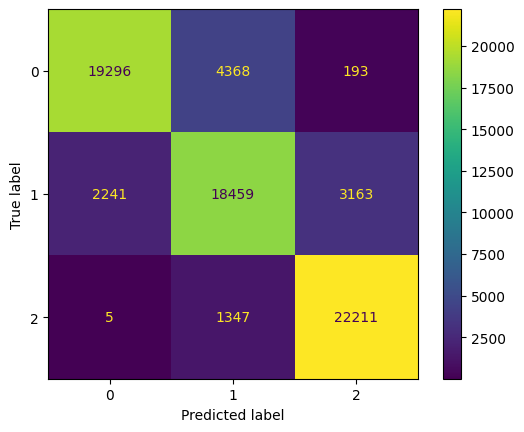

100%|██████████| 279/279 [00:06<00:00, 42.04it/s]


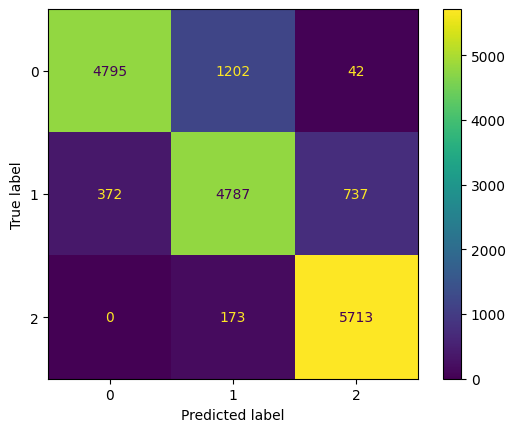

Epoch 1/20, Train Loss: 0.3838, Train F1: 0.8412,Test Loss: 0.3406, Test F1: 0.8583, 


100%|██████████| 1114/1114 [00:45<00:00, 24.51it/s]


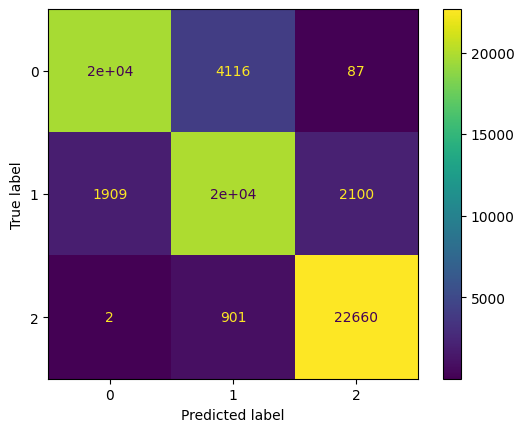

100%|██████████| 279/279 [00:06<00:00, 43.13it/s]


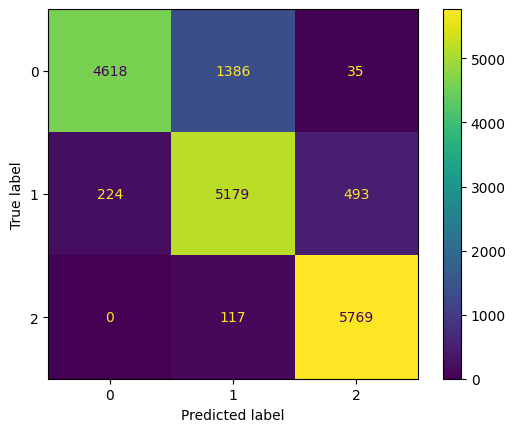

Epoch 2/20, Train Loss: 0.3051, Train F1: 0.8721,Test Loss: 0.3097, Test F1: 0.8734, 


100%|██████████| 1114/1114 [00:45<00:00, 24.59it/s]


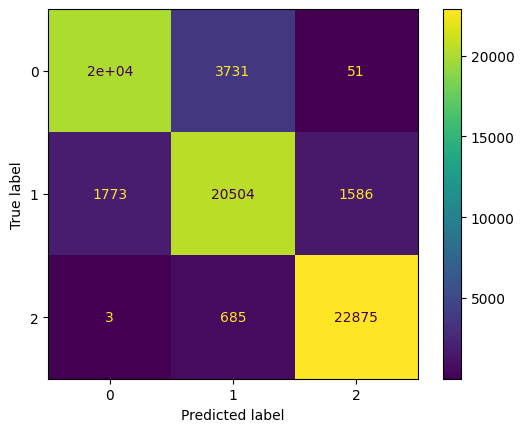

100%|██████████| 279/279 [00:06<00:00, 41.61it/s]


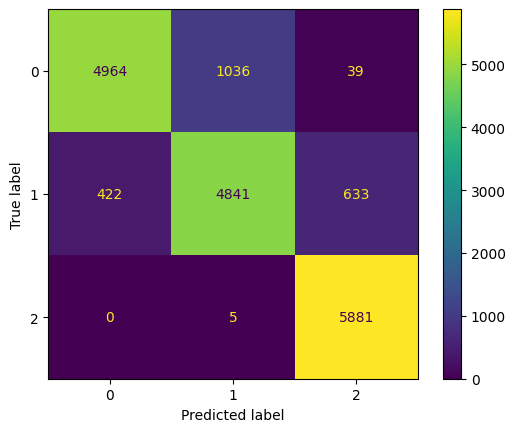

Epoch 3/20, Train Loss: 0.2591, Train F1: 0.8902,Test Loss: 0.2893, Test F1: 0.8801, 


100%|██████████| 1114/1114 [00:45<00:00, 24.66it/s]


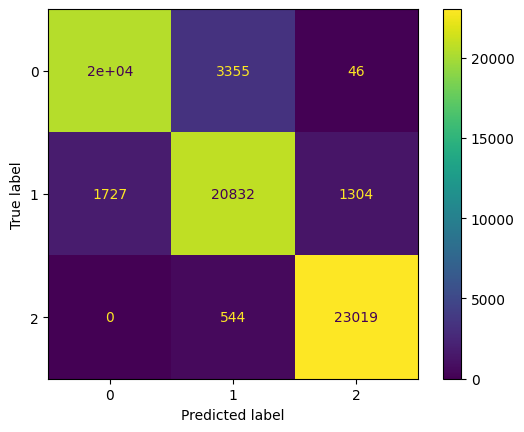

100%|██████████| 279/279 [00:06<00:00, 42.41it/s]


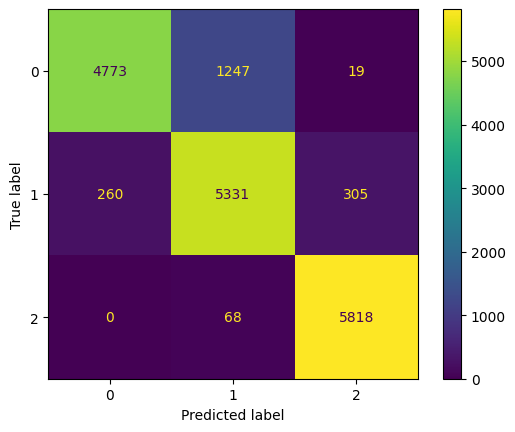

Epoch 4/20, Train Loss: 0.2296, Train F1: 0.9021,Test Loss: 0.2634, Test F1: 0.8933, 


100%|██████████| 1114/1114 [00:45<00:00, 24.48it/s]


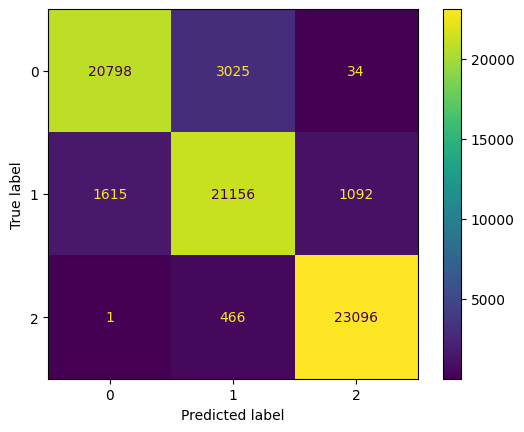

100%|██████████| 279/279 [00:06<00:00, 41.38it/s]


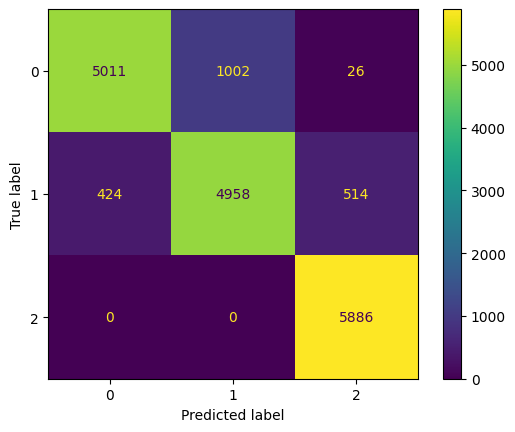

Epoch 5/20, Train Loss: 0.2061, Train F1: 0.9126,Test Loss: 0.2659, Test F1: 0.8896, 


100%|██████████| 1114/1114 [00:45<00:00, 24.52it/s]


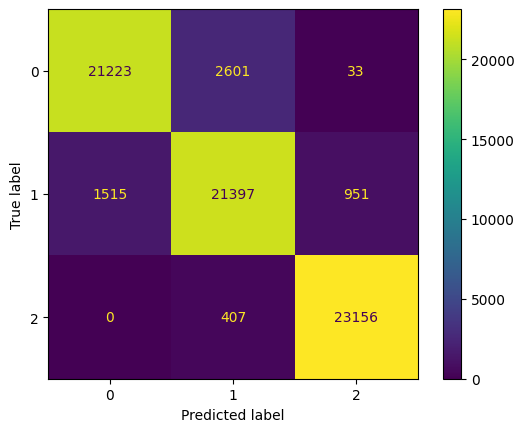

100%|██████████| 279/279 [00:06<00:00, 42.10it/s]


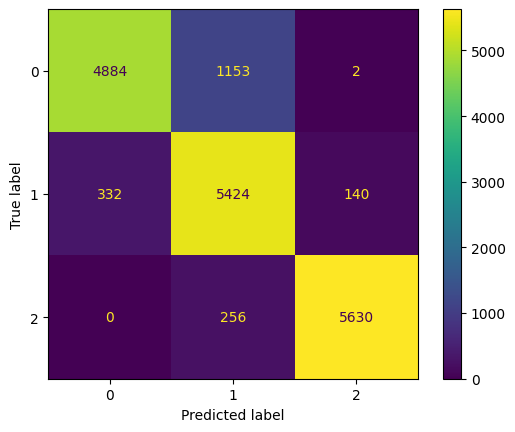

Epoch 6/20, Train Loss: 0.1839, Train F1: 0.9227,Test Loss: 0.2505, Test F1: 0.8943, 


100%|██████████| 1114/1114 [00:45<00:00, 24.62it/s]


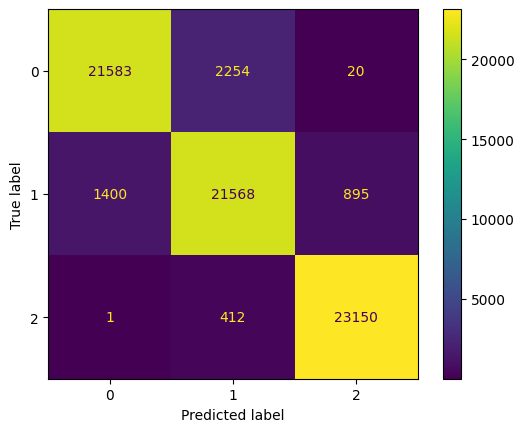

100%|██████████| 279/279 [00:06<00:00, 43.02it/s]


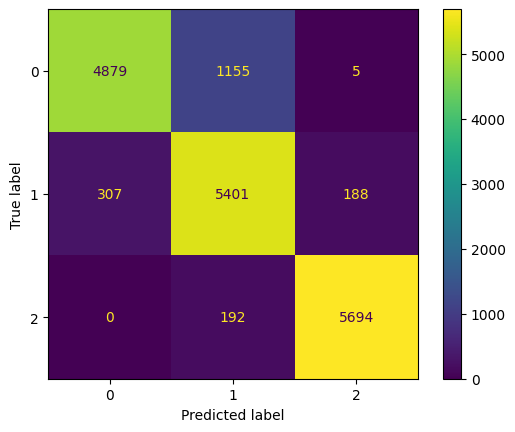

Epoch 7/20, Train Loss: 0.1674, Train F1: 0.9301,Test Loss: 0.2577, Test F1: 0.8964, 


100%|██████████| 1114/1114 [00:45<00:00, 24.37it/s]


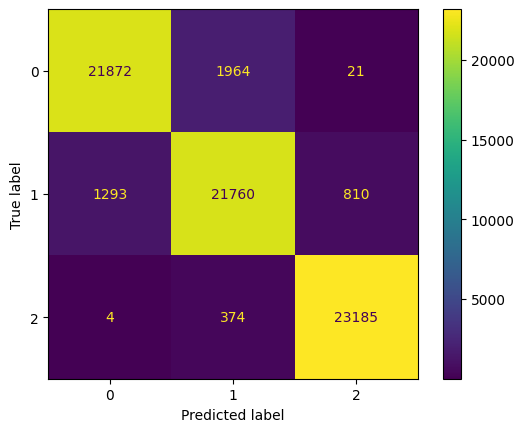

100%|██████████| 279/279 [00:06<00:00, 41.83it/s]


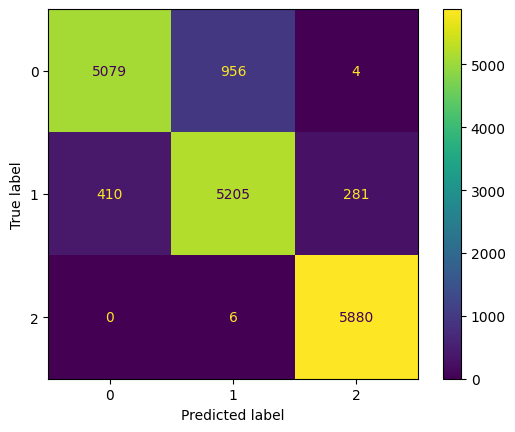

Epoch 8/20, Train Loss: 0.1521, Train F1: 0.9374,Test Loss: 0.2325, Test F1: 0.9069, 


100%|██████████| 1114/1114 [00:45<00:00, 24.57it/s]


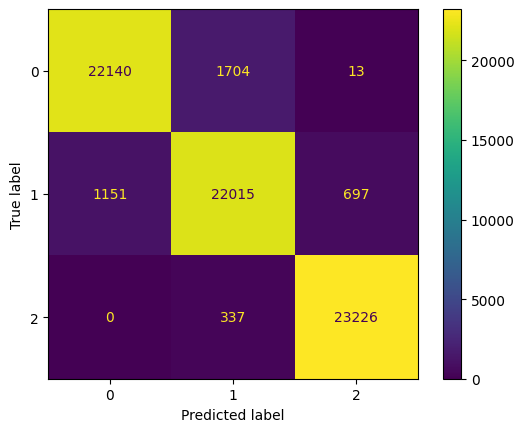

100%|██████████| 279/279 [00:06<00:00, 42.13it/s]


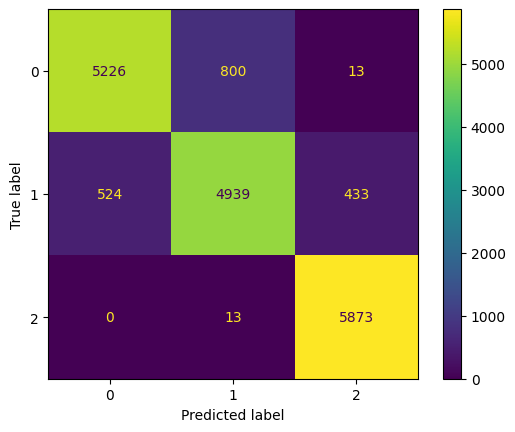

Epoch 9/20, Train Loss: 0.1363, Train F1: 0.9453,Test Loss: 0.2588, Test F1: 0.8999, 


100%|██████████| 1114/1114 [00:45<00:00, 24.55it/s]


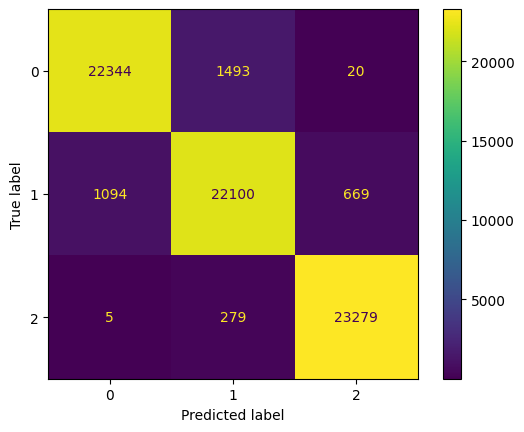

100%|██████████| 279/279 [00:06<00:00, 41.96it/s]


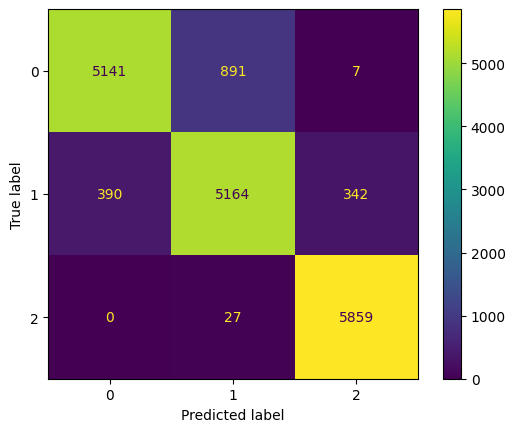

Epoch 10/20, Train Loss: 0.1256, Train F1: 0.9501,Test Loss: 0.2436, Test F1: 0.9070, 


100%|██████████| 1114/1114 [00:45<00:00, 24.36it/s]


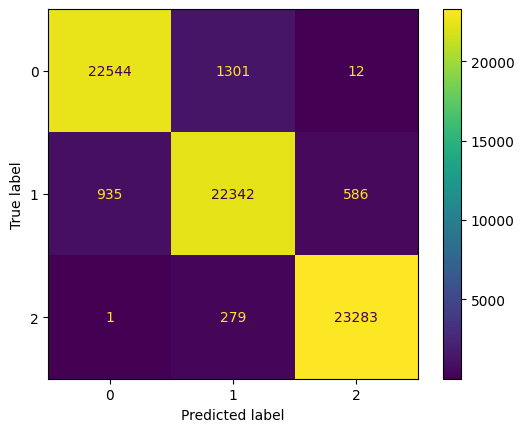

100%|██████████| 279/279 [00:06<00:00, 42.02it/s]


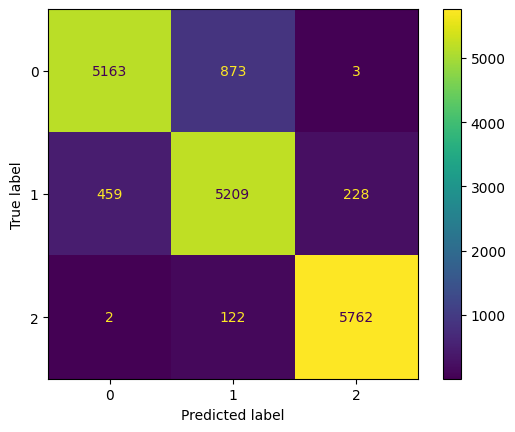

Epoch 11/20, Train Loss: 0.1119, Train F1: 0.9563,Test Loss: 0.2562, Test F1: 0.9054, 


100%|██████████| 1114/1114 [00:45<00:00, 24.38it/s]


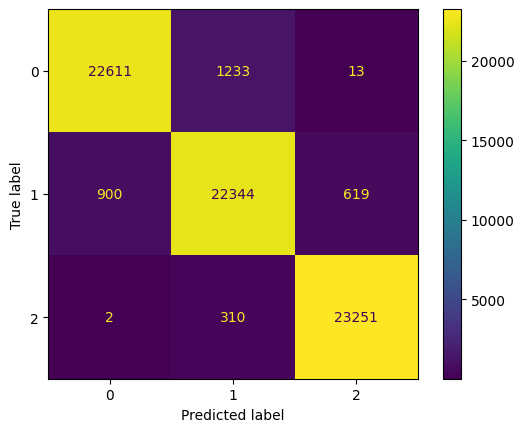

100%|██████████| 279/279 [00:06<00:00, 41.74it/s]


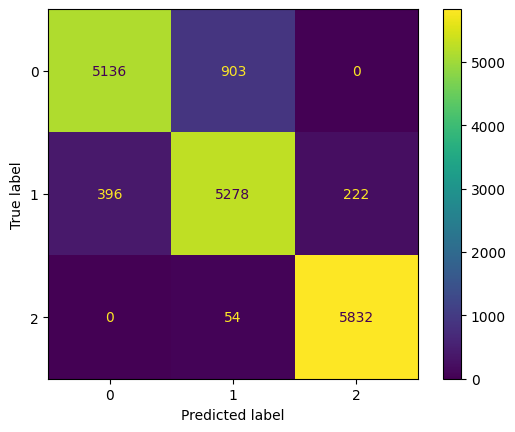

Epoch 12/20, Train Loss: 0.1087, Train F1: 0.9568,Test Loss: 0.2381, Test F1: 0.9116, 


100%|██████████| 1114/1114 [00:45<00:00, 24.56it/s]


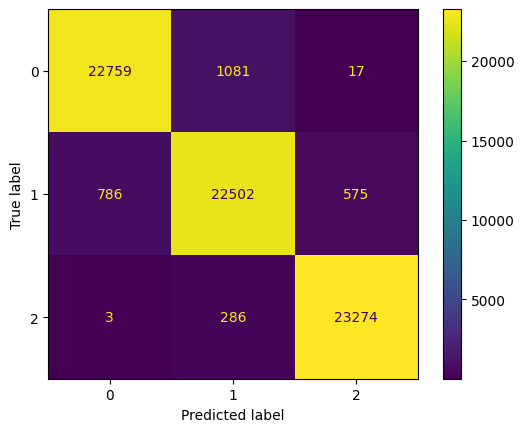

100%|██████████| 279/279 [00:06<00:00, 43.27it/s]


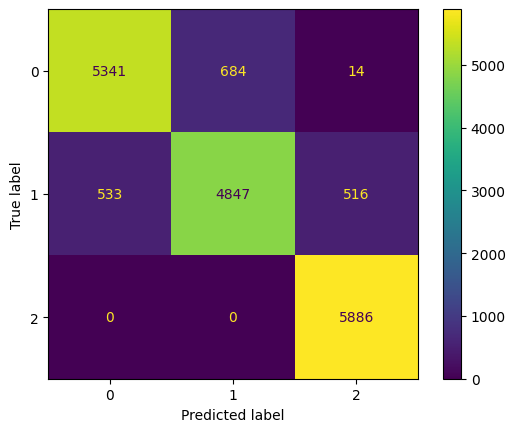

Epoch 13/20, Train Loss: 0.0993, Train F1: 0.9614,Test Loss: 0.2860, Test F1: 0.9020, 


100%|██████████| 1114/1114 [00:45<00:00, 24.61it/s]


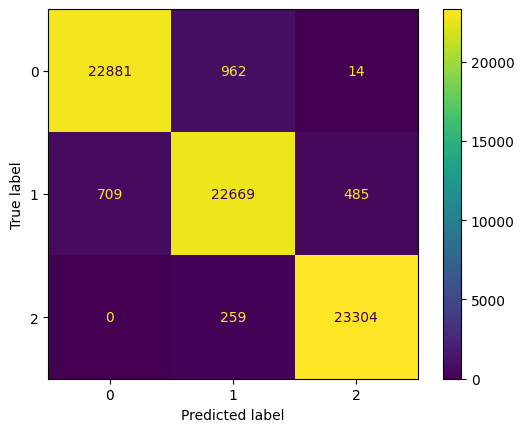

100%|██████████| 279/279 [00:06<00:00, 41.49it/s]


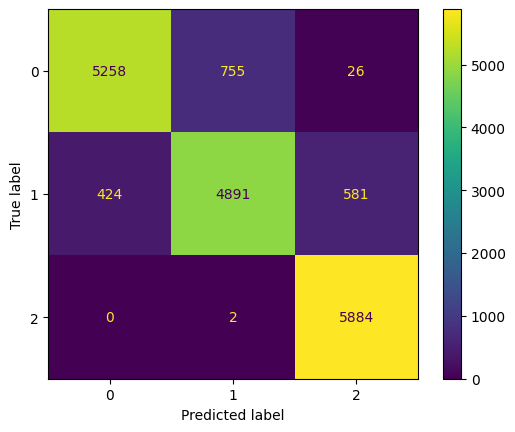

Epoch 14/20, Train Loss: 0.0873, Train F1: 0.9659,Test Loss: 0.3265, Test F1: 0.8997, 


100%|██████████| 1114/1114 [00:45<00:00, 24.71it/s]


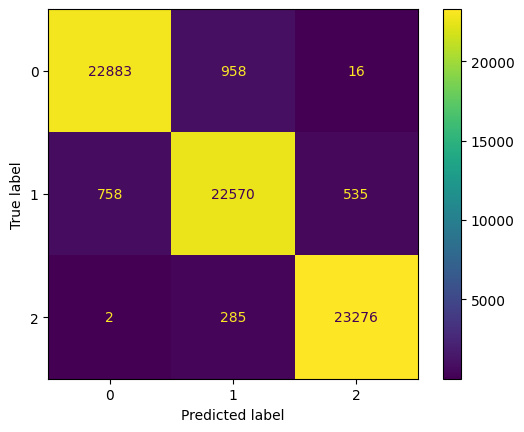

100%|██████████| 279/279 [00:06<00:00, 42.91it/s]


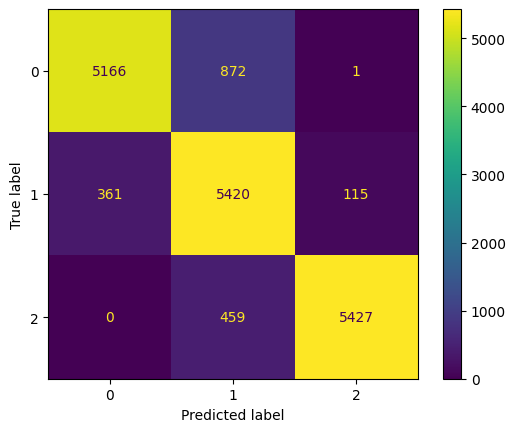

Epoch 15/20, Train Loss: 0.0916, Train F1: 0.9642,Test Loss: 0.2885, Test F1: 0.8985, 


100%|██████████| 1114/1114 [00:45<00:00, 24.59it/s]


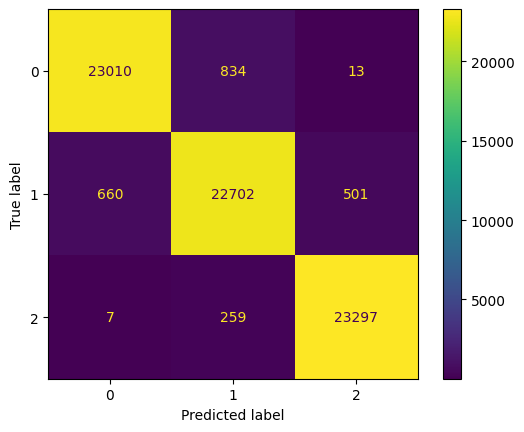

100%|██████████| 279/279 [00:06<00:00, 43.05it/s]


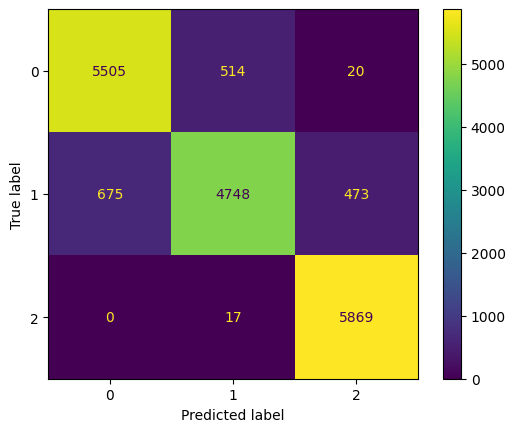

Epoch 16/20, Train Loss: 0.0832, Train F1: 0.9681,Test Loss: 0.2917, Test F1: 0.9046, 


100%|██████████| 1114/1114 [00:45<00:00, 24.65it/s]


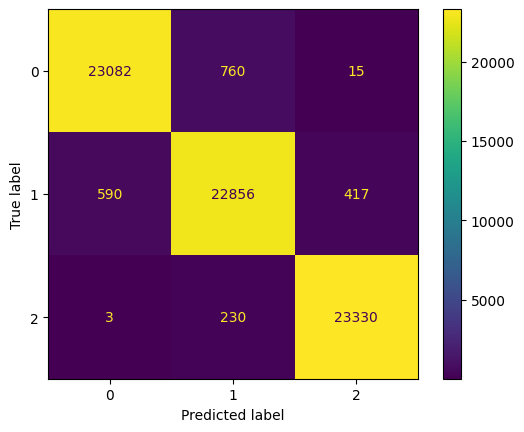

100%|██████████| 279/279 [00:06<00:00, 41.73it/s]


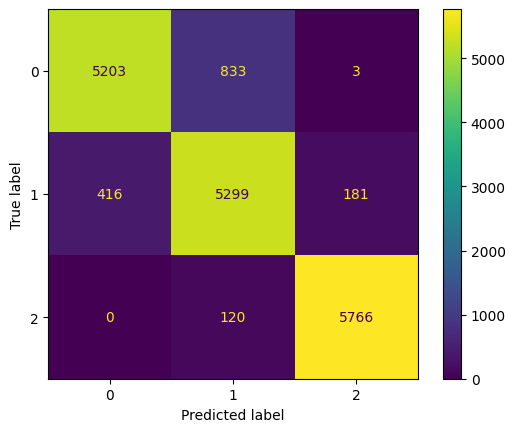

Epoch 17/20, Train Loss: 0.0761, Train F1: 0.9717,Test Loss: 0.2646, Test F1: 0.9128, 


100%|██████████| 1114/1114 [00:45<00:00, 24.65it/s]


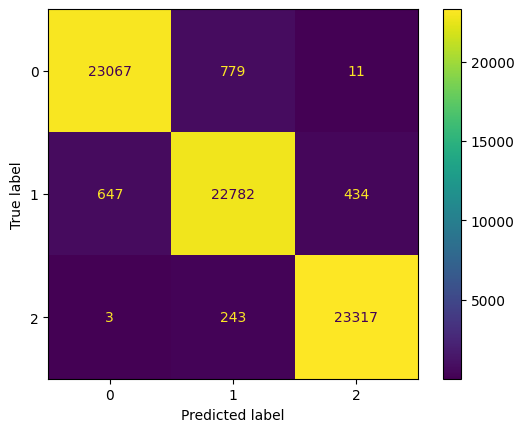

100%|██████████| 279/279 [00:06<00:00, 42.75it/s]


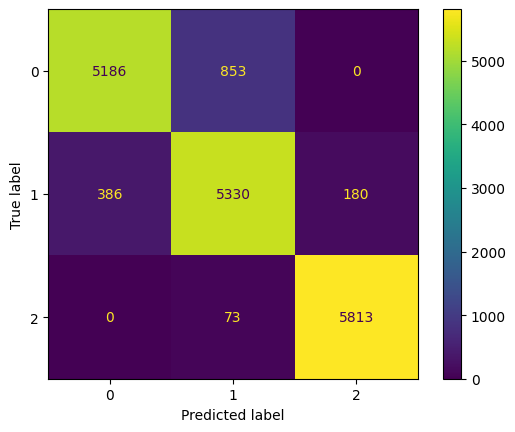

Epoch 18/20, Train Loss: 0.0764, Train F1: 0.9703,Test Loss: 0.2564, Test F1: 0.9162, 


100%|██████████| 1114/1114 [00:45<00:00, 24.60it/s]


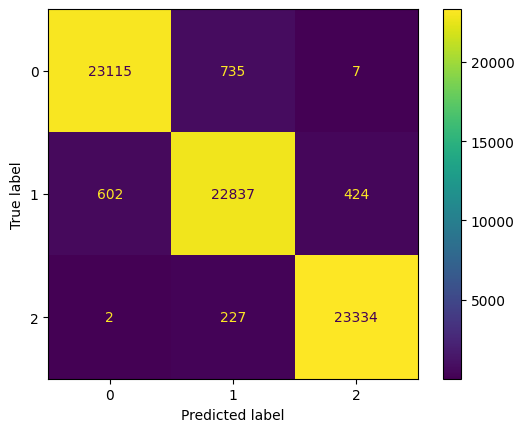

100%|██████████| 279/279 [00:06<00:00, 42.99it/s]


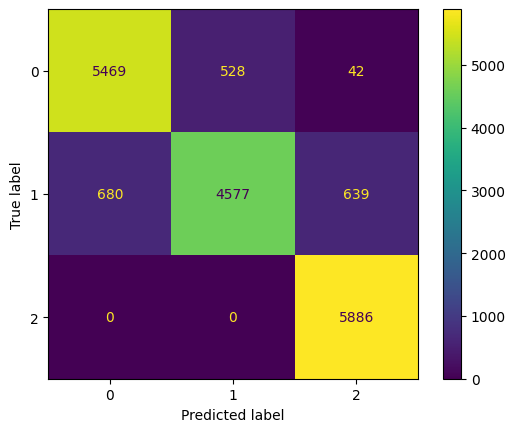

Epoch 19/20, Train Loss: 0.0738, Train F1: 0.9720,Test Loss: 0.3782, Test F1: 0.8940, 


In [53]:
mean_loss_train_resnet,mean_f1_train_resnet,mean_loss_test_resnet,mean_f1_test_resnet = train_final_model(resnet,train_looader,test_looader,n_epochs=CONFIG.epochs,optimizer=optimizer,criterion=criterion,device=device,model_name="resnet")

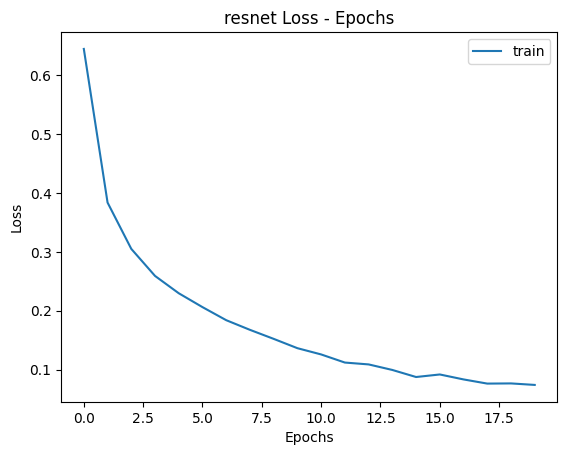

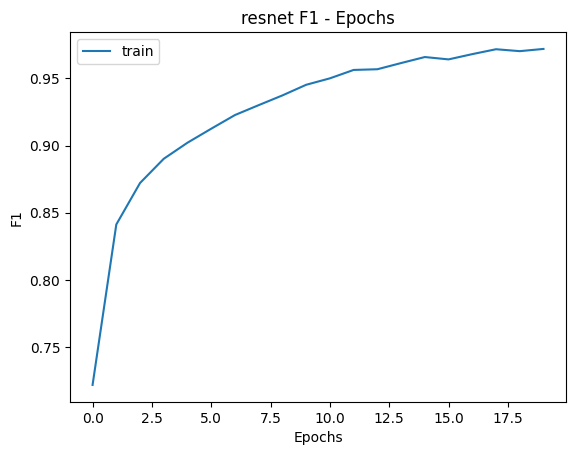

In [54]:
plot_model_metrics(mean_loss_train_resnet,mean_f1_train_resnet,model_name = "resnet",mode="train")

In [55]:
def plot_model_metrics_saath(mean_loss_train_list, mean_f1_train_list, name_list,mode):
    """
    Plots the training loss and F1 score over epochs.

    Args:
        mean_loss_train_list (list): List of mean training loss over epochs for different models.
        mean_f1_train_list (list): List of mean training F1 scores over epochs for different models.
        name_list (list): List of names for the different models.

    Returns:
        None
    """
    # Plot training loss over epochs
    plt.figure(figsize=(12, 6))
    for i in range(len(mean_loss_train_list)):
        plt.plot(mean_loss_train_list[i], label=f'{name_list[i]} - Loss')
    plt.title(mode+' Loss - Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot training F1 score over epochs
    plt.figure(figsize=(12, 6))
    for i in range(len(mean_f1_train_list)):
        plt.plot(mean_f1_train_list[i], label=f'{name_list[i]} - F1 Score')
    plt.title(mode+' F1 Score - Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.show()

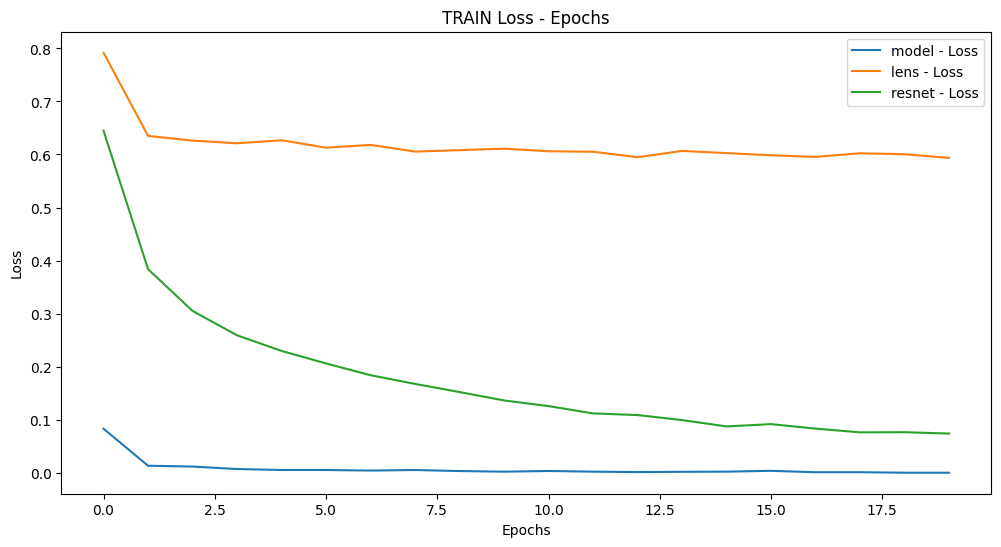

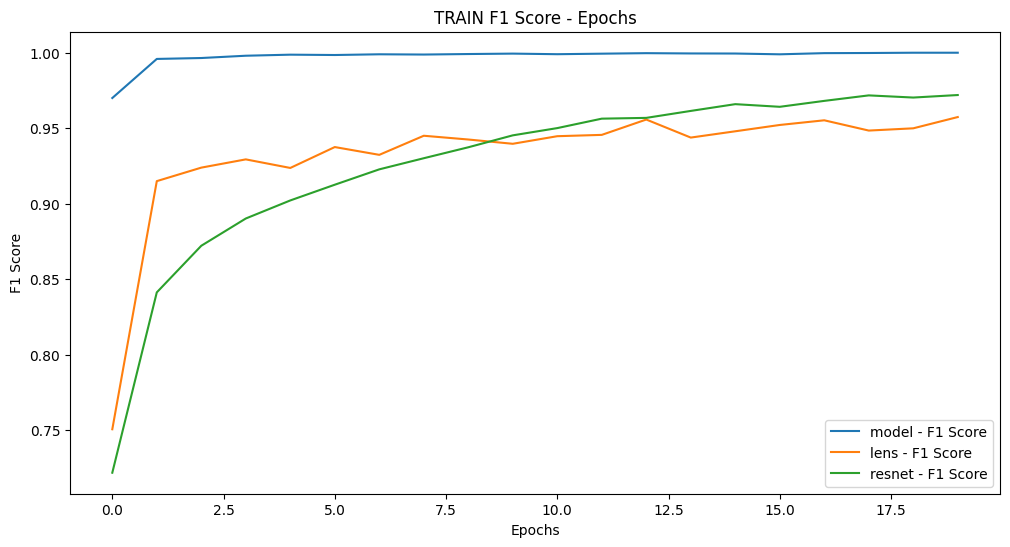

In [56]:
plot_model_metrics_saath([mean_loss_train_model,mean_loss_train_lens,mean_loss_train_resnet],[mean_f1_train_model,mean_f1_train_lens,mean_f1_train_resnet],["model","lens","resnet"],mode = "TRAIN")

performance on test data


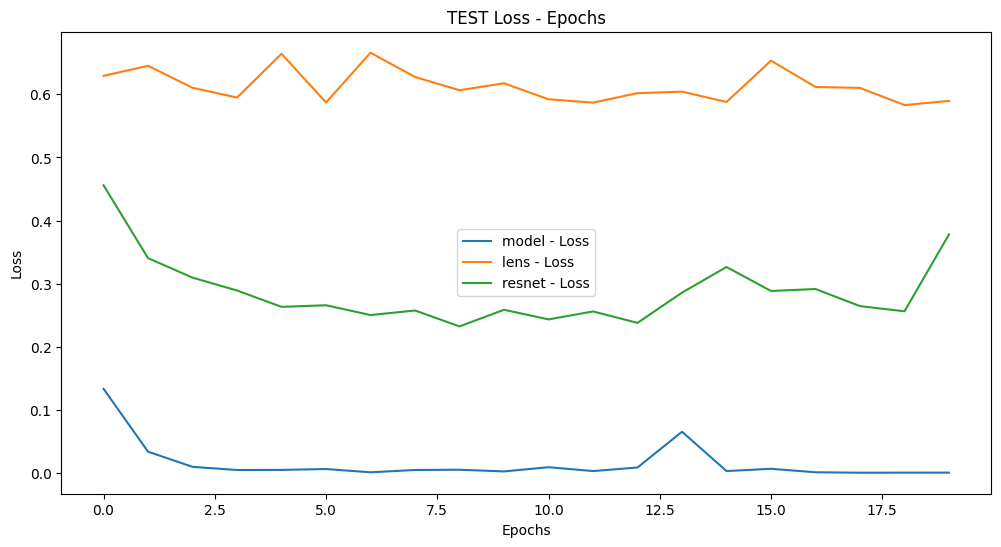

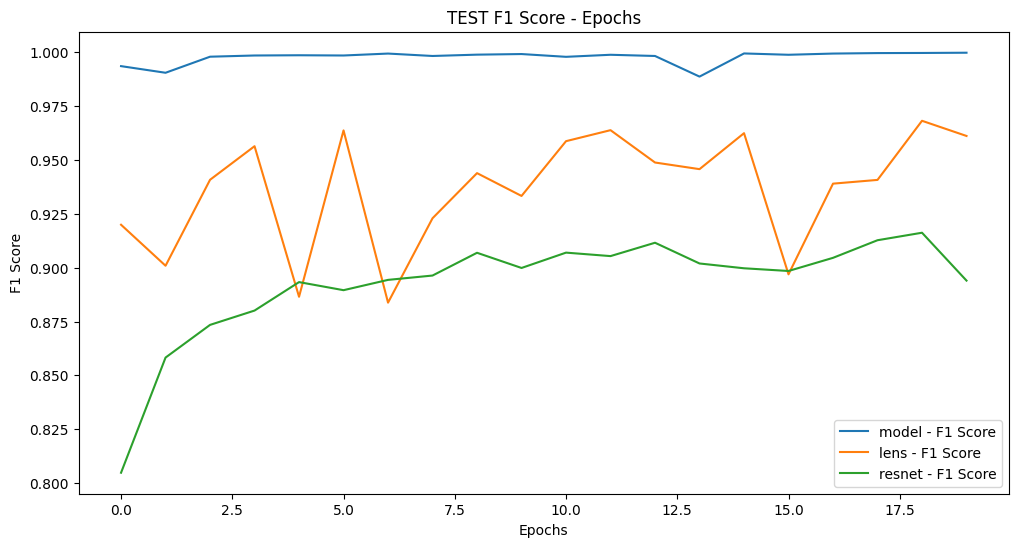

In [57]:
print("performance on test data")
plot_model_metrics_saath([mean_loss_test_model,mean_loss_test_lens,mean_loss_test_resnet],[mean_f1_test_model,mean_f1_test_lens,mean_f1_test_resnet],["model","lens","resnet"],mode = "TEST")

In [58]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder

In [59]:
one = OneHotEncoder()

In [60]:
import numpy as np
import torch
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import cycle
num_to_class = {0:"axion", 1:"cdm", 2:"no_sub"}
def ROC_AUC(model, test_loader, device, model_name):
    model.eval()
    y_true = []
    y_pred = []

    one = OneHotEncoder()

    # Turn off gradients for evaluation
    with torch.no_grad():
        for images, dis, targets in tqdm(test_loader):
            # Move data to device
            images, dis, targets = images.to(device), dis.to(device), targets.to(device)
            batch = images.shape[0]
            images = images.view(batch, 1, 64, 64)

            if model_name == "resnet":
                outputs = model(images)
            else:
                _, _, outputs = model(images, dis)

            # Collect predictions and labels
            preds = outputs.detach().cpu().numpy()
            labels = targets.detach().cpu().numpy()

            preds = [np.argmax(pred) for pred in preds]
            y_true.append(labels)
            y_pred.append(preds)

    y_true = np.hstack(y_true).reshape(-1)
    y_pred = np.hstack(y_pred).reshape(-1)

    one.fit(y_true.reshape(-1, 1))
    y_true = one.transform(y_true.reshape(-1, 1)).toarray()
    y_pred = one.transform(y_pred.reshape(-1, 1)).toarray()

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(CONFIG.n_class):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(CONFIG.n_class)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(CONFIG.n_class):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= CONFIG.n_class

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC AUC (area = {0:0.2f})'.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)
    plt.plot(fpr["macro"], tpr["macro"], label='macro-average ROC AUC(area = {0:0.2f})'.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(CONFIG.n_class), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of {num_to_class[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(model_name + ' Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()


100%|██████████| 279/279 [00:06<00:00, 45.51it/s]


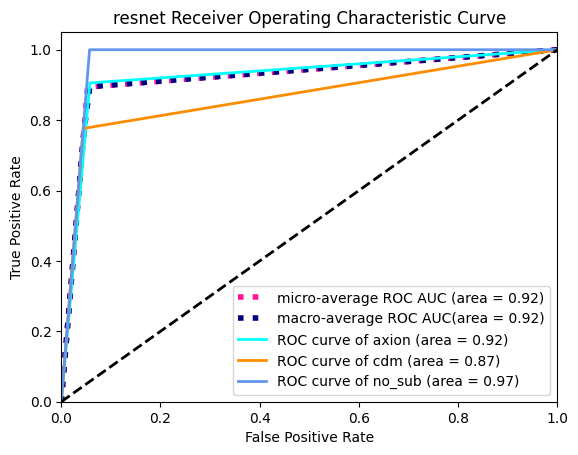

In [61]:
ROC_AUC(resnet,test_looader,device = "cuda",model_name = "resnet")

100%|██████████| 279/279 [00:28<00:00,  9.87it/s]


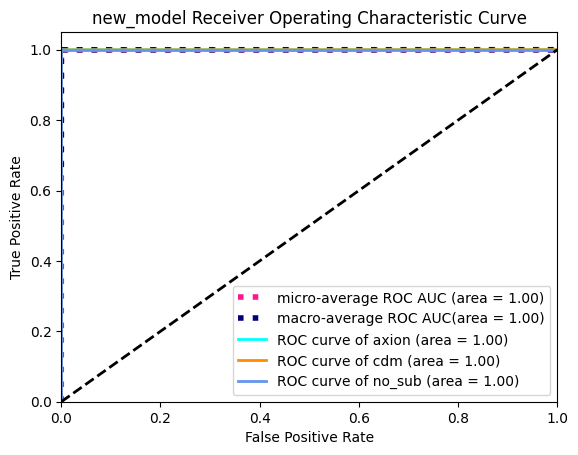

In [62]:
ROC_AUC(model,test_looader,device = "cuda",model_name = "new_model")

100%|██████████| 279/279 [00:20<00:00, 13.41it/s]


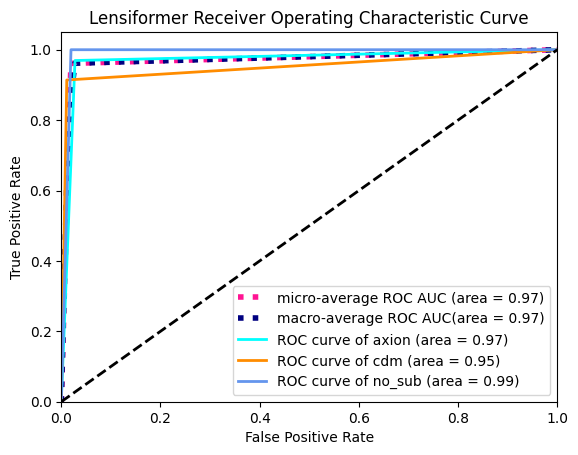

In [63]:
ROC_AUC(lens,test_looader,device = "cuda",model_name = "Lensiformer")

In [64]:
import numpy as np
import torch
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import cycle

def ROC_AUC(models, model_names, test_loader, device, n_classes):
    plt.figure()
    colors = cycle(['deeppink', 'navy', 'darkorange'])

    for model, model_name, color in zip(models, model_names, colors):
        model.eval()
        y_true = []
        y_pred = []

        one = OneHotEncoder()

        # Turn off gradients for evaluation
        with torch.no_grad():
            for images, dis, targets in tqdm(test_loader):
                # Move data to device
                images, dis, targets = images.to(device), dis.to(device), targets.to(device)
                batch = images.shape[0]
                images = images.view(batch, 1, 64, 64)

                if model_name == "resnet":
                    outputs = model(images)
                else:
                    _, _, outputs = model(images, dis)

                # Collect predictions and labels
                preds = outputs.detach().cpu().numpy()
                labels = targets.detach().cpu().numpy()

                preds = [np.argmax(pred) for pred in preds]
                y_true.append(labels)
                y_pred.append(preds)

        y_true = np.hstack(y_true).reshape(-1)
        y_pred = np.hstack(y_pred).reshape(-1)

        one.fit(y_true.reshape(-1, 1))
        y_true = one.transform(y_true.reshape(-1, 1)).toarray()
        y_pred = one.transform(y_pred.reshape(-1, 1)).toarray()

        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        # Compute macro-average ROC curve and ROC area
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        plt.plot(fpr["micro"], tpr["micro"], label=f'{model_name} micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
                 color=color, linestyle=':', linewidth=2)
        plt.plot(fpr["macro"], tpr["macro"], label=f'{model_name} macro-average ROC curve (area = {roc_auc["macro"]:0.2f})',
                 color=color, linestyle='-', linewidth=2)

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.savefig('roc_auc_comparison.png')
    plt.show()


100%|██████████| 279/279 [00:28<00:00,  9.88it/s]


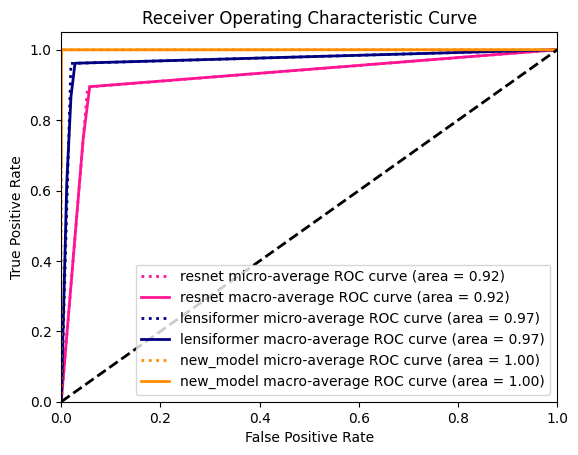

In [65]:
ROC_AUC([resnet,lens,model], ["resnet","lensiformer","new_model"], test_looader, "cuda", 3)